# Test and Visualize Results

In [2]:
import json
import ray
from ray import tune
from model import RNN,  Base
from utils import plot_data, get_input_data, get_dataloader, get_input_data_1D
import os
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Utility funtions

In [3]:
def get_config(json_config_path):
    with open(json_config_path, 'r') as fp:
        best_config = json.load(fp)
    # best_config['dir'] = "./logs/experiments_2D/"
    return best_config


In [4]:
def load_model(params):
    print(f'Loading {params["model_name"]} model...')
    model = Base(input_size=params['input_size'], 
                hidden_size = params["hidden_size"],
                num_layers = params["num_layers"],
                output_size=1 if params['data_dim'] == 1 else 3,
                model = params['model_name']
                )

    # last_checkpoint = 'model_191_0.00757762653609881.pth'
    # last_checkpoint = 'model_132_0.05770279822441248.pth' # lstm ln
    # last_checkpoint = "model_191_917.6316366195679.pth"
    # last_checkpoint = params['dir']

    # print(f'Loading model: {last_checkpoint} from {params["dir"]}...')
    if os.path.isdir(params['dir']):
        chkpoints_list = [i for i in os.listdir(params['dir']) if i.startswith("checkpoint")]
        last_checkpoint = sorted(chkpoints_list, key=lambda x: int(x.split('_')[-1]))[-1]
        chkpoint_state_dict, optim = torch.load(os.path.join(params['dir'], last_checkpoint, 'checkpoint'))

    else:
        # chkpoint_state_dict, optim = torch.load(os.path.join(params['dir']))
        try:
            chkpoint_state_dict, optim = torch.load(os.path.join(params['dir']))
        except:
            chkpoint_state_dict = torch.load(os.path.join(params['dir']))
        
    model.load_state_dict(chkpoint_state_dict)
    return model

In [5]:
def test_accuracy(net, test_loader, device="cpu"):

    net.to(device)
    net.eval()
    # criterion = nn.L1Loss()
    criterion = nn.MSELoss()
    loss = 0
    # total = 0
    test_pred = []
    with torch.no_grad():
        for data in test_loader:
            input, labels = data
            input, labels = input.to(device), labels.to(device)
            outputs, _ = net(input)
            # _, predicted = torch.max(outputs.data, 1)
            loss += criterion(outputs, labels).cpu().numpy()
            test_pred.append(outputs.cpu().numpy())
    return loss / len(test_loader), np.concatenate(np.array(test_pred), axis=0)


In [6]:
def get_loss(pred, labels, metric = "mae"):
    if metric == "mae":
        criterion = nn.L1Loss()
    elif metric == "mse":
        criterion = nn.MSELoss()
    return criterion(torch.tensor(pred).clone().detach() , torch.tensor(labels)).item()

In [7]:
def get_all_mae(pred, labels, metric):
    all_losses = []
    for i in range(pred.shape[1]): # output size 
        all_losses.append(get_loss(pred[:, i], labels[:, i], metric=metric))
    return all_losses, get_loss(pred[:, 0], labels[:, 0]) # return mse for x, y, theta and total mse


In [8]:
def show_trajectory(nn_preds, dataset, lim = -1, save_plots=False, save_dir=None, save_name=None):

    output_dim = nn_preds.shape[1]
    
    plt.figure(figsize=(20, 10))
    
    gt = np.array(dataset[1])
    kalman_pred = np.array(dataset[2])
    if output_dim == 3:
        ekf_pred = np.array(dataset[3])
        ukf_pred = np.array(dataset[4])    

        # plot x and y on two axis
        # plt.subplot(2, 1, 1)
        plt.plot(nn_preds[:lim, 0], nn_preds[:lim, 1], label='NN pred')
        plt.plot(gt[:lim, 0], gt[:lim, 1], label='GT')
        plt.plot(kalman_pred[:lim, 0], kalman_pred[:lim, 1], label='Kalman pred')
        plt.plot(ekf_pred[:lim, 0], ekf_pred[:lim, 1], label='EKF pred')
        plt.plot(ukf_pred[:lim, 0], ukf_pred[:lim, 1], label='UKF pred')

        plt.legend(['NN pred', 'GT', 'Kalman pred', 'EKF pred', 'UKF pred'])
    

        # # plt.subplot(3, 1, 1)
        # plt.plot(nn_preds[:lim, 0], label='X pred')
        # plt.plot(gt[:lim, 0], label='X true')
        # plt.plot(kalman_pred[:lim, 0], label='X kalman')
        # plt.plot(ekf_pred[:lim, 0], label='X EKF')
        # plt.plot(ukf_pred[:lim, 0], label='X UKF')
        # plt.legend(['X pred', 'X true', 'X kalman', 'X ekf', 'X ukf'])

        # # plt.subplot(3, 1, 2)
        # plt.plot(nn_preds[:lim, 1], label='Y pred')
        # plt.plot(gt[:lim, 1], label='Y true')
        # plt.plot(kalman_pred[:lim, 1], label='Y kalman')
        # plt.plot(ekf_pred[:lim, 1], label='Y EKF')
        # plt.plot(ukf_pred[:lim, 1], label='Y UKF')
        # plt.legend(['Y pred', 'Y true', 'Y kalman', 'Y ekf', 'Y ukf'])

        # plt.subplot(3, 1, 3)
        # plt.plot(nn_preds[:lim, 2], label='Theta pred')
        # plt.plot(gt[:lim, 2], label='Theta true')
        # plt.plot(kalman_pred[:lim, 2], label='Theta kalman')
        # plt.plot(ekf_pred[:lim, 2], label='Theta EKF')
        # plt.plot(ukf_pred[:lim, 2], label='Theta UKF')
        # plt.legend(['Theta pred', 'Theta true', 'Theta kalman', 'Theta ekf', 'Theta ukf'])
        # if save_plots:
        #     plt.savefig(os.path.join(save_dir, f'{save_name}.png'))

    elif output_dim==1:
        plt.plot(nn_preds[:lim], label='NN pred')
        plt.plot(gt[:lim], label='GT')
        plt.plot(kalman_pred[:lim], label='Kalman pred')
        plt.legend(['NN pred', 'GT', 'Kalman Pred'])
        if save_plots:
            plt.savefig(os.path.join(save_dir, f'{save_name}.png'))
    else:
        # invalid dim error
        raise ValueError("Invalid dim")
    
    # plt.legend()
    if not save_plots:
        plt.show()


In [9]:
def show_plots(nn_preds, dataset, lim = -1, save_plots=False, save_dir=None, save_name=None):

    output_dim = nn_preds.shape[1]
    
    
    gt = np.array(dataset[1])
    kalman_pred = np.array(dataset[2])
    if output_dim == 3:
        plt.figure(figsize=(20, 10))
        ekf_pred = np.array(dataset[3])
        ukf_pred = np.array(dataset[4])
        # ekf_pred = np.array(dataset[3])
        # ukf_pred = np.array(dataset[4])    

        plt.subplot(3, 1, 1)
        plt.plot(nn_preds[:lim, 0], label='X pred')
        plt.plot(gt[:lim, 0], label='X true')
        plt.plot(kalman_pred[:lim, 0], label='X kalman')
        plt.plot(ekf_pred[:lim, 0], label='X EKF')
        plt.plot(ukf_pred[:lim, 0], label='X UKF')
        plt.legend(['X pred', 'X true', 'X kalman', 'X ekf', 'X ukf'])

        plt.subplot(3, 1, 2)
        plt.plot(nn_preds[:lim, 1], label='Y pred')
        plt.plot(gt[:lim, 1], label='Y true')
        plt.plot(kalman_pred[:lim, 1], label='Y kalman')
        plt.plot(ekf_pred[:lim, 1], label='Y EKF')
        plt.plot(ukf_pred[:lim, 1], label='Y UKF')
        plt.legend(['Y pred', 'Y true', 'Y kalman', 'Y ekf', 'Y ukf'])

        plt.subplot(3, 1, 3)
        plt.plot(nn_preds[:lim, 2], label='Theta pred')
        plt.plot(gt[:lim, 2], label='Theta true')
        plt.plot(kalman_pred[:lim, 2], label='Theta kalman')
        plt.plot(ekf_pred[:lim, 2], label='Theta EKF')
        plt.plot(ukf_pred[:lim, 2], label='Theta UKF')
        plt.legend(['Theta pred', 'Theta true', 'Theta kalman', 'Theta ekf', 'Theta ukf'])
        if save_plots:
            plt.savefig(os.path.join(save_dir, f'{save_name}.png'))

    elif output_dim==1:
        plt.figure(figsize=(15, 8))
        plt.plot(nn_preds[:lim], label='NN pred')
        plt.plot(gt[:lim], label='GT')
        plt.plot(kalman_pred[:lim], label='Kalman pred')
        # plt.plot(ekf_pred[:lim], label='EKF pred')
        # plt.plot(ukf_pred[:lim], label='UKF pred')
        # plt.legend(['NN pred', 'GT', 'Kalman Pred', 'EKF pred', 'UKF pred'])
        plt.legend(['NN pred', 'GT', 'Kalman Pred'])
        if save_plots:
            plt.savefig(os.path.join(save_dir, f'{save_name}.png'))
    else:
        # invalid dim error
        raise ValueError("Invalid dim")
    
    # plt.legend()
    if not save_plots:
        plt.show()


In [10]:
def get_csv_results(eval_csv_dir, params):
    config = get_config(params["json_config_path"])
    config.update(params)
    print(f"config: {config}")

    model = load_model(config)

    # test_df = pd.read_csv(EVAL_DATA_DIR)
    if params["data_dim"] == 2:
        test_dataset = get_input_data(seq_len = config['sequence_length'], 
                    batch_size = config['batch_size'], datadir=eval_csv_dir)

        # common
        test_loader = get_dataloader(test_dataset[0], test_dataset[1], batch_size=config['batch_size'])
        loss, nn_preds = test_accuracy(model, test_loader, device='cpu')
        # return nn_preds, test_dataset, model, test_loader
        print(f"Test loss: {loss}")

        kalman_pred = np.array(test_dataset[2])
        ekf_pred = np.array(test_dataset[3])
        ukf_pred = np.array(test_dataset[4])
        
        nn_loss_dims, nn_loss = get_all_mae(nn_preds, test_dataset[1], metric=params['loss'])
        # print(f"NN MSE: {nn_loss_dims}, {nn_loss}")
        kf_loss_dims, kf_loss = get_all_mae(kalman_pred, test_dataset[1], metric=params['loss'])
        # print(f"KF MSE: {kf_loss_dims}, {kf_loss}")
        ekf_loss_dims, ekf_loss = get_all_mae(ekf_pred, test_dataset[1], metric=params['loss'])
        # print(f"EKF MSE: {ekf_loss_dims}, {ekf_loss}")
        ukf_loss_dims, ukf_loss = get_all_mae(ukf_pred, test_dataset[1], metric=params['loss'])
        # print(f"UKF MSE: {ukf_loss_dims}, {ukf_loss}")

        show_plots(nn_preds, test_dataset, lim=params["plot_limit"], save_plots=params["save_plots"], save_dir=params["save_dir"], save_name=params["save_name"])
        return kf_loss_dims, kf_loss, nn_loss_dims, nn_loss, ekf_loss_dims, ekf_loss, ukf_loss_dims, ukf_loss

    else:
        test_dataset = get_input_data_1D(seq_len = config['sequence_length'], 
                    batch_size = config['batch_size'], datadir=eval_csv_dir)
        
        # common
        test_loader = get_dataloader(test_dataset[0], test_dataset[1], batch_size=config['batch_size'])
        print(f'len test loader: {len(test_loader)}')
        loss, nn_preds = test_accuracy(model, test_loader, device='cpu')
        print(f"Test loss: {loss}")
        print(f"Test dataset shape: {len(test_dataset)} and  {test_dataset[0].shape}")

        kalman_pred = np.array(test_dataset[2])
        # ekf_pred = np.array(test_dataset[3])
        # ukf_pred = np.array(test_dataset[4])

        nn_loss = get_loss(nn_preds, test_dataset[1])
        print(f"NN MSE: {nn_loss}")
        kf_loss = get_loss(kalman_pred, test_dataset[1])
        print(f"KF MSE: {kf_loss}")
        # ekf_loss = get_loss(ekf_pred, test_dataset[1])
        # print(f"EKF MSE: {ekf_loss}")
        # ukf_loss = get_loss(ukf_pred, test_dataset[1])
        # print(f"UKF MSE: {ukf_loss}")


        # nn_loss_dims, nn_loss = (nn_preds, test_dataset[1])
        # print(f"NN MSE: {nn_loss_dims}, {nn_loss}")
        # kf_loss_dims, kf_loss = get_all_mae(kalman_pred, test_dataset[1])
        # print(f"KF MSE: {kf_loss_dims}, {kf_loss}")

        show_plots(nn_preds, test_dataset, lim=params["plot_limit"], save_plots=params["save_plots"], save_dir=params["save_dir"], save_name=params["save_name"])
        # return nn_loss, kf_loss, ekf_loss, ukf_loss
        return nn_loss, kf_loss




In [11]:
def get_results(params, test_set_name, data_dim=2, model_name="LSTM_ln"):
    if data_dim == 2:
        kalman_mse_x = []
        kalman_mse_y = []
        kalman_mse_theta = []

        nn_mse_x = []
        nn_mse_y = []
        nn_mse_theta = []

        ekf_mse_x = []
        ekf_mse_y = []
        ekf_mse_theta = []

        ukf_mse_x = []
        ukf_mse_y = []
        ukf_mse_theta = []

        kalman_mse_total = []
        nn_mse_total = []
        ekf_mse_total = []
        ukf_mse_total = []

        test_set = []
        test_model = []

        for csv_name in os.listdir(params['eval_dir_path']):
            csv_dir = os.path.join(params['eval_dir_path'], csv_name)
            params['save_name'] = csv_name.split(".")[0] # for saving plots
            mse_array = get_csv_results(csv_dir, params)
            # return get_csv_results(csv_dir, params)

            kf_loss_dims = mse_array[0]
            kf_loss = mse_array[1]
            nn_loss_dims = mse_array[2]
            nn_loss = mse_array[3]
            ekf_loss_dims = mse_array[4]
            ekf_loss = mse_array[5]
            ukf_loss_dims = mse_array[6]
            ukf_loss = mse_array[7]

            kalman_mse_total.append(kf_loss)
            nn_mse_total.append(nn_loss)
            ekf_mse_total.append(ekf_loss)
            ukf_mse_total.append(ukf_loss)

            kalman_mse_x.append(kf_loss_dims[0])
            kalman_mse_y.append(kf_loss_dims[1])
            kalman_mse_theta.append(kf_loss_dims[2])

            ekf_mse_x.append(ekf_loss_dims[0])
            ekf_mse_y.append(ekf_loss_dims[1])
            ekf_mse_theta.append(ekf_loss_dims[2])

            ukf_mse_x.append(ukf_loss_dims[0])
            ukf_mse_y.append(ukf_loss_dims[1])
            ukf_mse_theta.append(ukf_loss_dims[2])

            nn_mse_x.append(nn_loss_dims[0])
            nn_mse_y.append(nn_loss_dims[1])
            nn_mse_theta.append(nn_loss_dims[2])

            test_set.append(csv_dir)
            test_model.append(model_name)


            print("====================================")
            print("====================================")
            print("====================================")

        results_dict = {
            "Test set": [test_set_name[i] for i in test_set],
            "Test model": test_model,

            "Kalman MAE": kalman_mse_total,
            "NN MAE": nn_mse_total,
            "EKF MAE": ekf_mse_total,
            "UKF MAE": ukf_mse_total,

            "Kalman MAE X": kalman_mse_x,
            "NN MAE X": nn_mse_x,
            "EKF MAE X": ekf_mse_x,
            "UKF MAE X": ukf_mse_x,

            "Kalman MAE Y": kalman_mse_y,
            "NN MAE Y": nn_mse_y,
            "EKF MAE Y": ekf_mse_y,
            "UKF MAE Y": ukf_mse_y,

            "Kalman MAE Theta": kalman_mse_theta,
            "NN MAE Theta": nn_mse_theta,
            "EKF MAE Theta": ekf_mse_theta,
            "UKF MAE Theta": ukf_mse_theta,
        }

        lstm_2d_results_df = pd.DataFrame.from_dict(results_dict)
        
        return lstm_2d_results_df

    if data_dim == 1:
            kalman_mse_x = []
            nn_mse_x = []
            ekf_mse_x = []
            ukf_mse_x = []

            kalman_mse_total = []
            nn_mse_total = []
            ekf_mse_total = []
            ukf_mse_total = []

            test_set = []
            test_model = []

            for csv_name in os.listdir(params['eval_dir_path']):
                csv_dir = os.path.join(params['eval_dir_path'], csv_name)

                params['save_name'] = csv_name.split(".")[0] # for saving plots
                mse_array = get_csv_results(csv_dir, params)

                nn_loss = mse_array[0]
                kf_loss = mse_array[1]

                kalman_mse_total.append(kf_loss)
                nn_mse_total.append(nn_loss)

                test_set.append(csv_dir)
                test_model.append(model_name)


                print("====================================")
                print("====================================")
                print("====================================")

            results_dict = {
                "Test set": [test_set_name[i] for i in test_set],
                "Test model": test_model,

                "Kalman MAE": kalman_mse_total,
                "NN MAE": nn_mse_total,
            }

            total_results_1d = pd.DataFrame.from_dict(results_dict)
            
            return total_results_1d

In [12]:
def test_setup(data_dim, model_name="LSTM_ln", save_plots=True, loss_metric = 'mae', plot_lim = -1, dataset = None):
    if dataset != None:     
        json_config_path = f'./logs/separate_mae/experiments_{data_dim}D/{dataset}/best_config_{model_name}.json'
    else:
        # json_config_path = f'./logs/appended_mae/experiments_{data_dim}D/best_config_{model_name}.json'
        json_config_path = f'./logs/appended_mae/experiments_{data_dim}D/best_config_{model_name}.json'
         
         
    eval_dir_path = f"data/{data_dim}D/evaluation_data"

    params = {
        "batch_size": 100,
        "model_name": model_name,
        "input_size": 19 if data_dim == 2 else 9,
        "output_size": 3 if data_dim == 2 else 1,
        'model_name': model_name,
        'data_dim': data_dim,
        "json_config_path": json_config_path,
        "data_dim": data_dim,
        "plot_limit": plot_lim, # -1 for all
        "save_plots": save_plots,
        "save_dir": f"./results/{data_dim}D/{model_name}/plots",
        'eval_dir_path': eval_dir_path,
        'loss': loss_metric,
    }

    if data_dim == 2:
            test_set_name = {
                            'data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv': 'Intel 1',
                            'data/2D/evaluation_data/fbcampus_alpha_4_run_2_merged.csv': 'FB Campus 1',
                            'data/2D/evaluation_data/fbcampus_alpha_8_run_2_merged.csv': 'FB Campus 2',
                            'data/2D/evaluation_data/intel_alpha_4_run_2_merged.csv': 'Intel 2'
                }
    else:
        test_set_name = {
                        'data/1D/evaluation_data/mnst_2_lnstd_10.csv': 'MNST 0',
                        'data/1D/evaluation_data/mnst_2_lnstd_0.01.csv': 'MNST 1',
                        'data/1D/evaluation_data/mnst_4_lnstd_0.01.csv': 'MNST 2',
                        'data/1D/evaluation_data/mnst_2_lnstd_1.csv': 'MNST 3',
                        'data/1D/evaluation_data/mnst_2_lnstd_0.1.csv': 'MNST 4',
                        'data/1D/evaluation_data/mnst_8_lnstd_0.01.csv': 'MNST 5'
                        }

    os.makedirs(params["save_dir"], exist_ok=True)

    return params, test_set_name

In [13]:
def save_results(all_resutls_df, model_name="LSTM_ln", data_dim=2):
    os.makedirs(f'./results/{data_dim}D/{model_name}/', exist_ok=True)
    if data_dim == 2:
        lstm_ln_2d_results_all = all_resutls_df[['Test set', 'Test model', 'Kalman MAE', 'NN MAE', 'EKF MAE', 'UKF MAE']]
        lstm_ln_2d_results_x = all_resutls_df[['Test set', 'Test model', 'Kalman MAE X', 'NN MAE X', 'EKF MAE X', 'UKF MAE X']]
        lstm_ln_2d_results_y = all_resutls_df[['Test set', 'Test model', 'Kalman MAE Y', 'NN MAE Y', 'EKF MAE Y', 'UKF MAE Y']]
        lstm_ln_2d_results_theta = all_resutls_df[['Test set', 'Test model', 'Kalman MAE Theta', 'NN MAE Theta', 'EKF MAE Theta', 'UKF MAE Theta']]
        # lstm_ln_2d_results_all

        lstm_ln_2d_results_all.set_index(['Test model', 'Test set']).to_csv(f"./results/{data_dim}D/{model_name}/results_overall.csv")
        lstm_ln_2d_results_x.set_index(['Test model', 'Test set']).to_csv(f"./results/{data_dim}D/{model_name}/results_x.csv")
        lstm_ln_2d_results_y.set_index(['Test model', 'Test set']).to_csv(f"./results/{data_dim}D/{model_name}/results_y.csv")
        lstm_ln_2d_results_theta.set_index(['Test model', 'Test set']).to_csv(f"./results/{data_dim}D/{model_name}/results_theta.csv")

    elif data_dim == 1:
        over_all_df = all_resutls_df[['Test set','Test model', 'Kalman MAE', 'NN MAE']]
        over_all_df.set_index(['Test model', 'Test set']).to_csv(f"./results/{data_dim}D/{model_name}/results_overall.csv")


# 2D Results

## LSTM_LN

config: {'dir': '/home/rufael.marew/ray_results/train_ray_2023-05-07_21-12-10/train_ray_4f3e3_00015_15_hidden_size=32,lr=0.0003,num_layers=4,sequence_length=38_2023-05-10_07-51-57', 'hidden_size': 32, 'lr': 0.0003375731235573559, 'metric': 0.08212178166096028, 'num_layers': 4, 'sequence_length': 38, 'batch_size': 100, 'model_name': 'LSTM_ln', 'input_size': 19, 'output_size': 3, 'data_dim': 2, 'json_config_path': './logs/appended_mae/experiments_2D/best_config_LSTM_ln.json', 'plot_limit': 200, 'save_plots': True, 'save_dir': './results/2D/LSTM_ln/plots', 'eval_dir_path': 'data/2D/evaluation_data', 'loss': 'mae', 'save_name': 'fbcampus_alpha_8_run_2_merged'}
Loading LSTM_ln model...
Test loss: 0.21130303999311045
config: {'dir': '/home/rufael.marew/ray_results/train_ray_2023-05-07_21-12-10/train_ray_4f3e3_00015_15_hidden_size=32,lr=0.0003,num_layers=4,sequence_length=38_2023-05-10_07-51-57', 'hidden_size': 32, 'lr': 0.0003375731235573559, 'metric': 0.08212178166096028, 'num_layers': 4, '

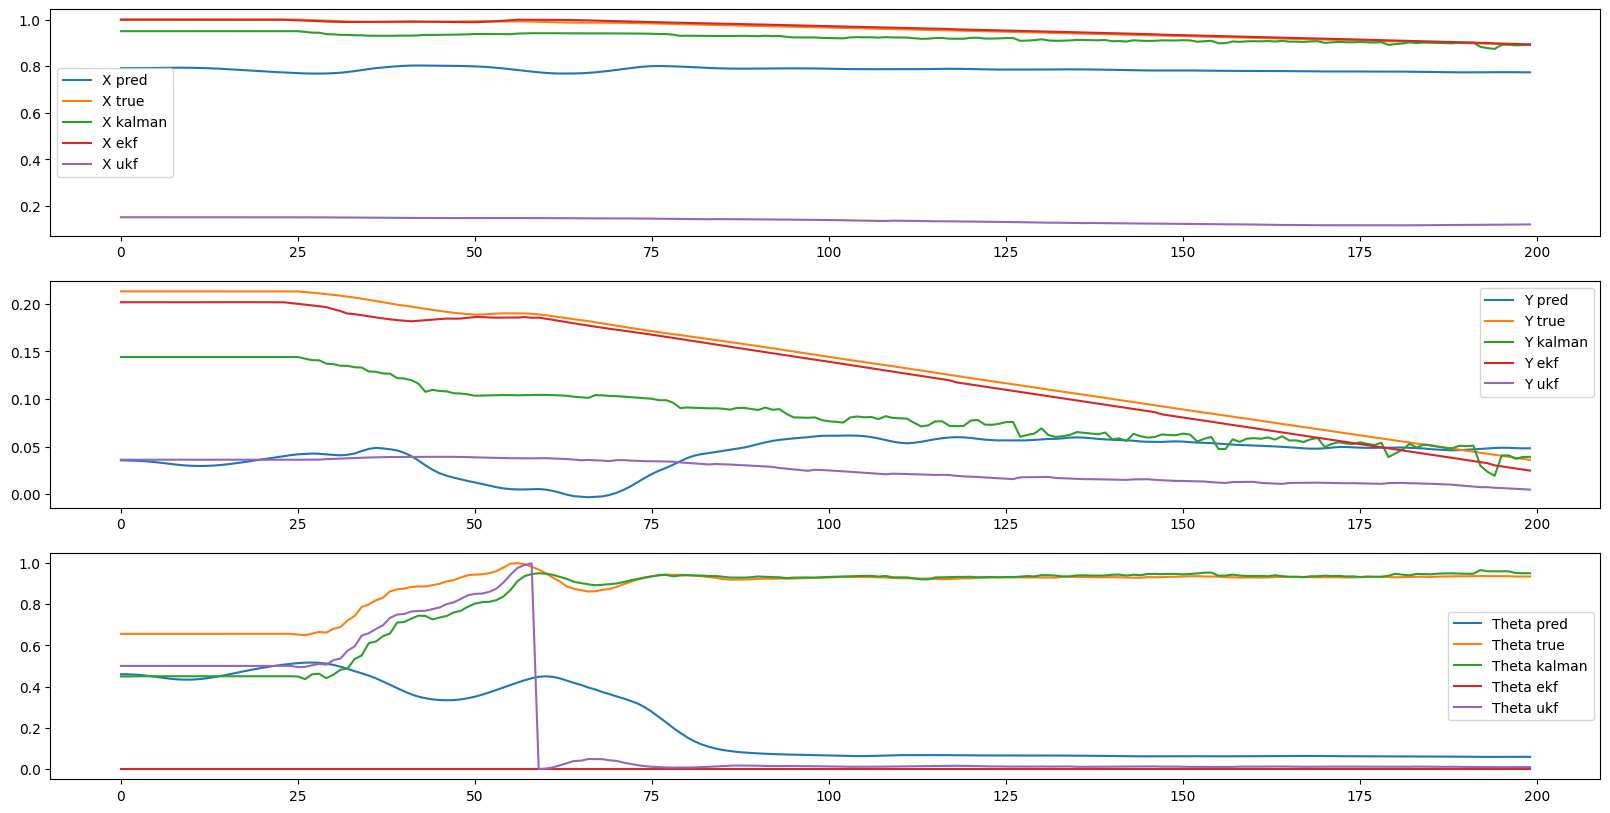

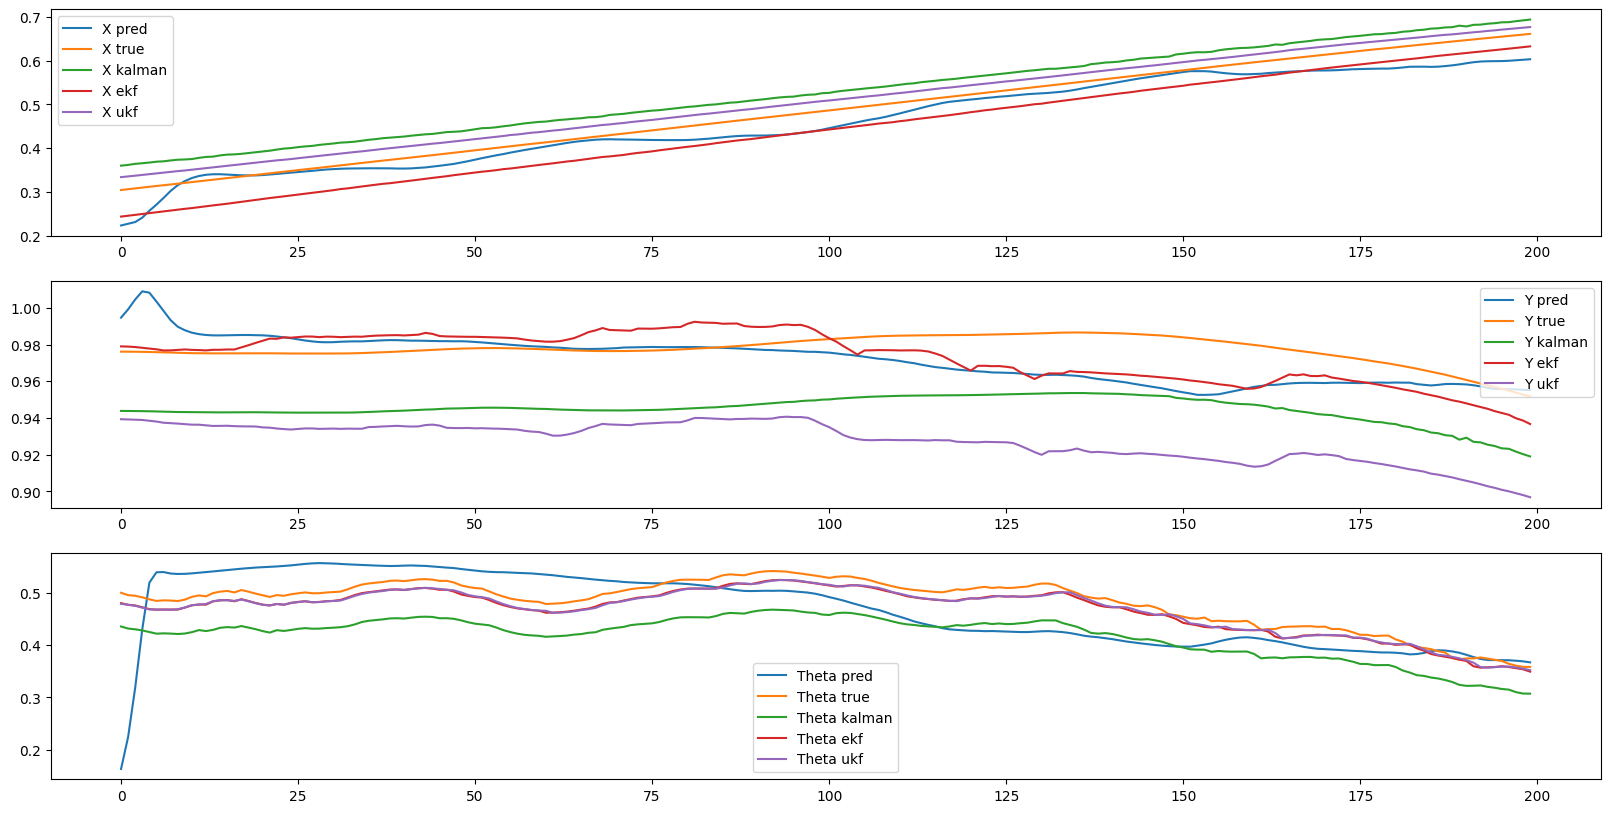

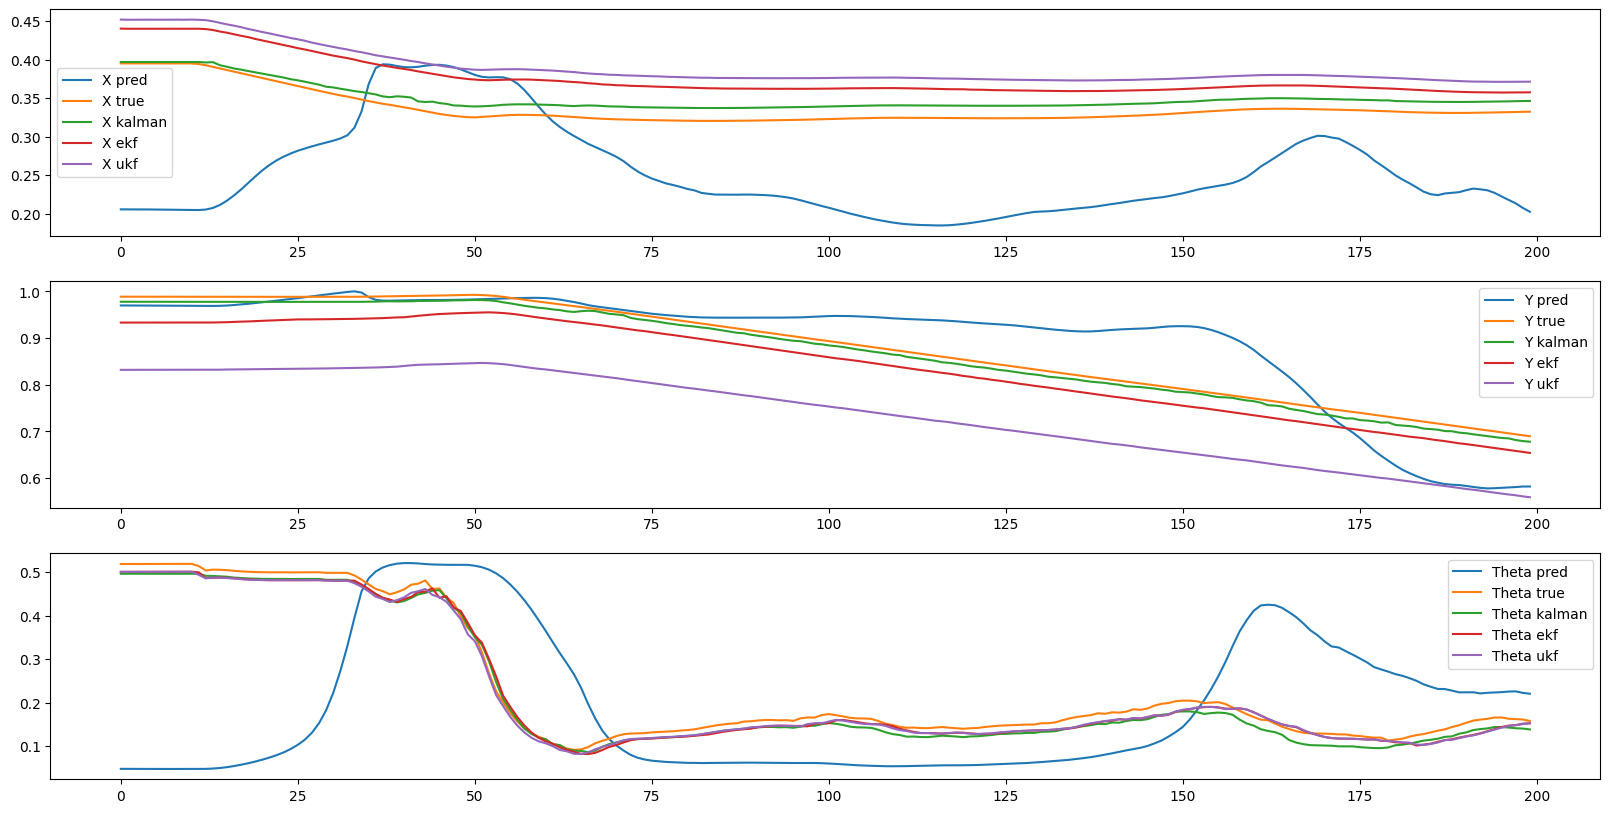

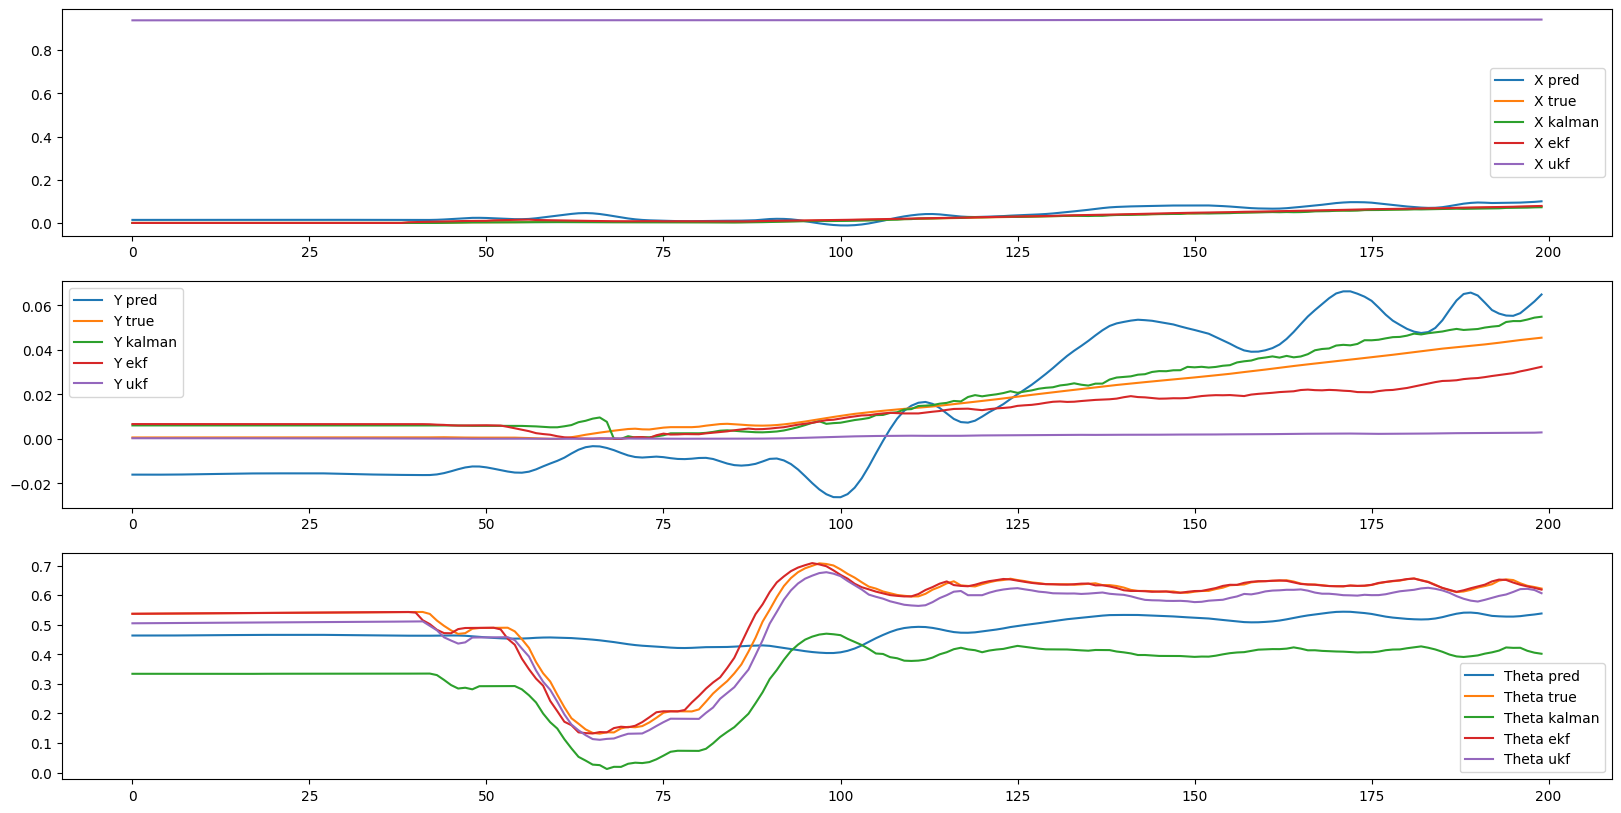

In [14]:
data_dim = 2
model_name = "LSTM_ln"
params, test_set_name = test_setup(data_dim=2, model_name=model_name, plot_lim=200)

lstm_ln_2d_results_df = get_results(params, test_set_name, model_name=model_name)
# save_results(lstm_ln_2d_results_df, model_name=model_name, data_dim=data_dim)

In [17]:
lstm_ln_2d_results_df

Test set Test model  Kalman MAE    NN MAE   EKF MAE   UKF MAE   
0  FB Campus 2    LSTM_ln    0.078613  0.162752  0.026203  0.260478  \
1      Intel 1    LSTM_ln    0.044180  0.057301  0.038003  0.019466   
2      Intel 2    LSTM_ln    0.032754  0.101207  0.039427  0.029918   
3  FB Campus 1    LSTM_ln    0.033728  0.072859  0.020327  0.339105   

   Kalman MAE X  NN MAE X  EKF MAE X  UKF MAE X  Kalman MAE Y  NN MAE Y   
0      0.078613  0.162752   0.026203   0.260478      0.079829  0.131525  \
1      0.044180  0.057301   0.038003   0.019466      0.021308  0.051827   
2      0.032754  0.101207   0.039427   0.029918      0.013613  0.065957   
3      0.033728  0.072859   0.020327   0.339105      0.064715  0.091215   

   EKF MAE Y  UKF MAE Y  Kalman MAE Theta  NN MAE Theta  EKF MAE Theta   
0   0.007583   0.233076          0.166582      0.703210       0.824231  \
1   0.025946   0.038701          0.342355      0.513099       0.422663   
2   0.041805   0.078142          0.183666      0.125328       0.214339   
3   0.025449   0.357053          0.266904      0.136561       0.050467   

   UKF MAE Theta  
0       0.188952  
1       0.423152  
2       0.209185  
3       0.071311

In [18]:
# nn_preds, test_dataset, model, test_loader = lstm_ln_2d_results_df

In [19]:
# get_loss(nn_preds, test_dataset[1])

# loss, nn_pred_s = test_accuracy(model, test_loader, device='cpu')

In [20]:
# nn_preds[0], nn_pred_s[0]

## LSTM 

config: {'dir': 'logs/appended_mae/experiments_2D/model_best_LSTM.pth', 'dir_2': '/home/rufael.marew/ray_results/train_ray_2023-05-07_20-31-33/train_ray_a2b3c_00009_9_hidden_size=8,lr=0.0006,num_layers=12,sequence_length=38_2023-05-07_20-53-03', 'hidden_size': 8, 'lr': 0.0005522389433178991, 'metric': 0.1475361283008869, 'num_layers': 12, 'sequence_length': 38, 'batch_size': 100, 'model_name': 'LSTM', 'input_size': 19, 'output_size': 3, 'data_dim': 2, 'json_config_path': './logs/appended_mae/experiments_2D/best_config_LSTM.json', 'plot_limit': -1, 'save_plots': True, 'save_dir': './results/2D/LSTM/plots', 'eval_dir_path': 'data/2D/evaluation_data', 'loss': 'mae', 'save_name': 'fbcampus_alpha_8_run_2_merged'}
Loading LSTM model...
Test loss: 0.15155093273834178
config: {'dir': 'logs/appended_mae/experiments_2D/model_best_LSTM.pth', 'dir_2': '/home/rufael.marew/ray_results/train_ray_2023-05-07_20-31-33/train_ray_a2b3c_00009_9_hidden_size=8,lr=0.0006,num_layers=12,sequence_length=38_2023-

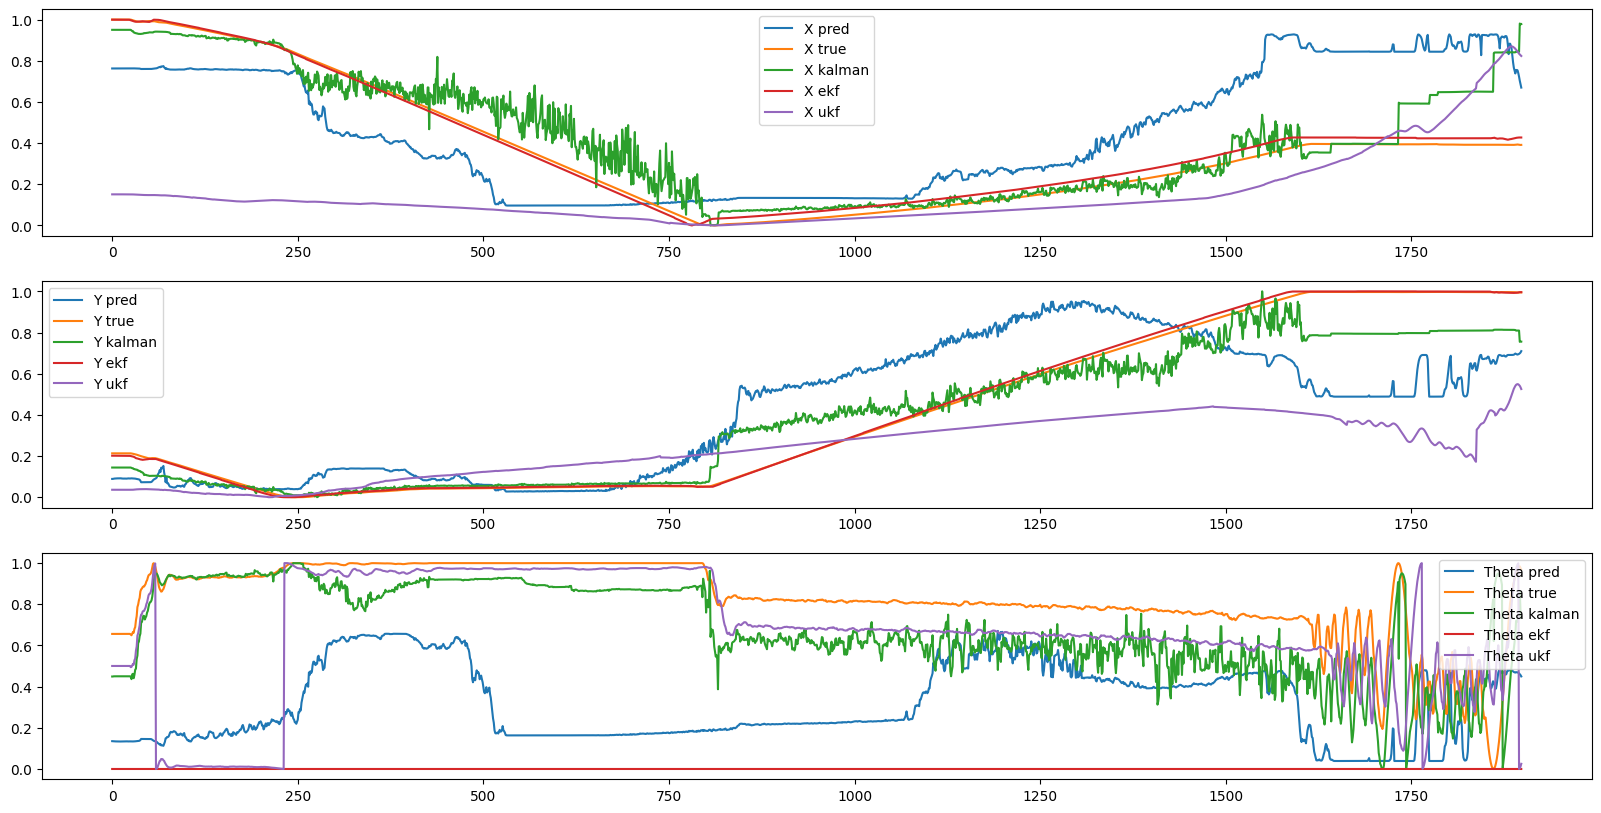

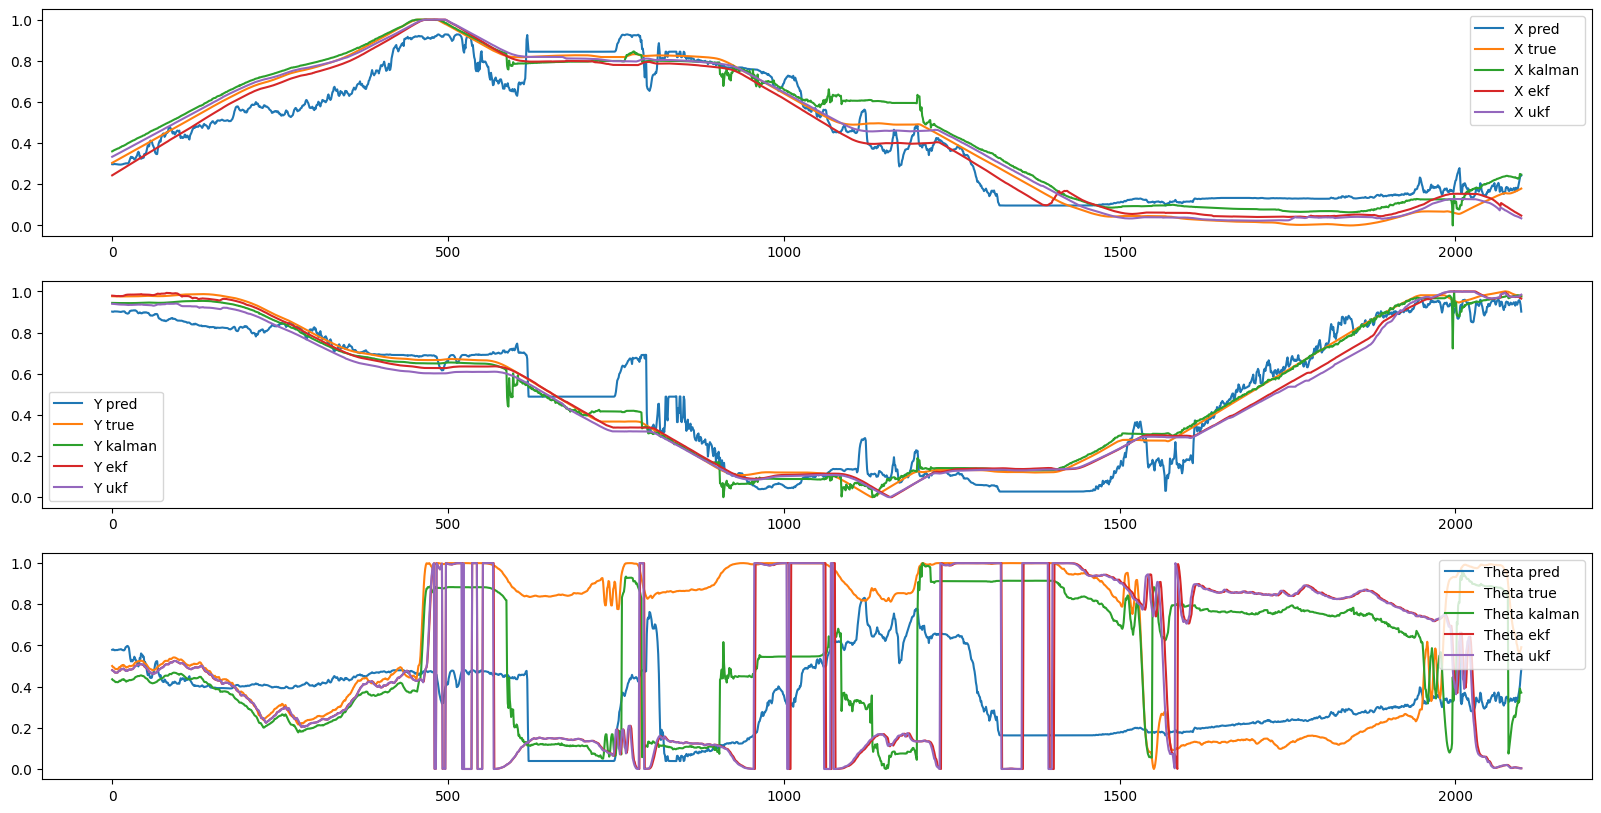

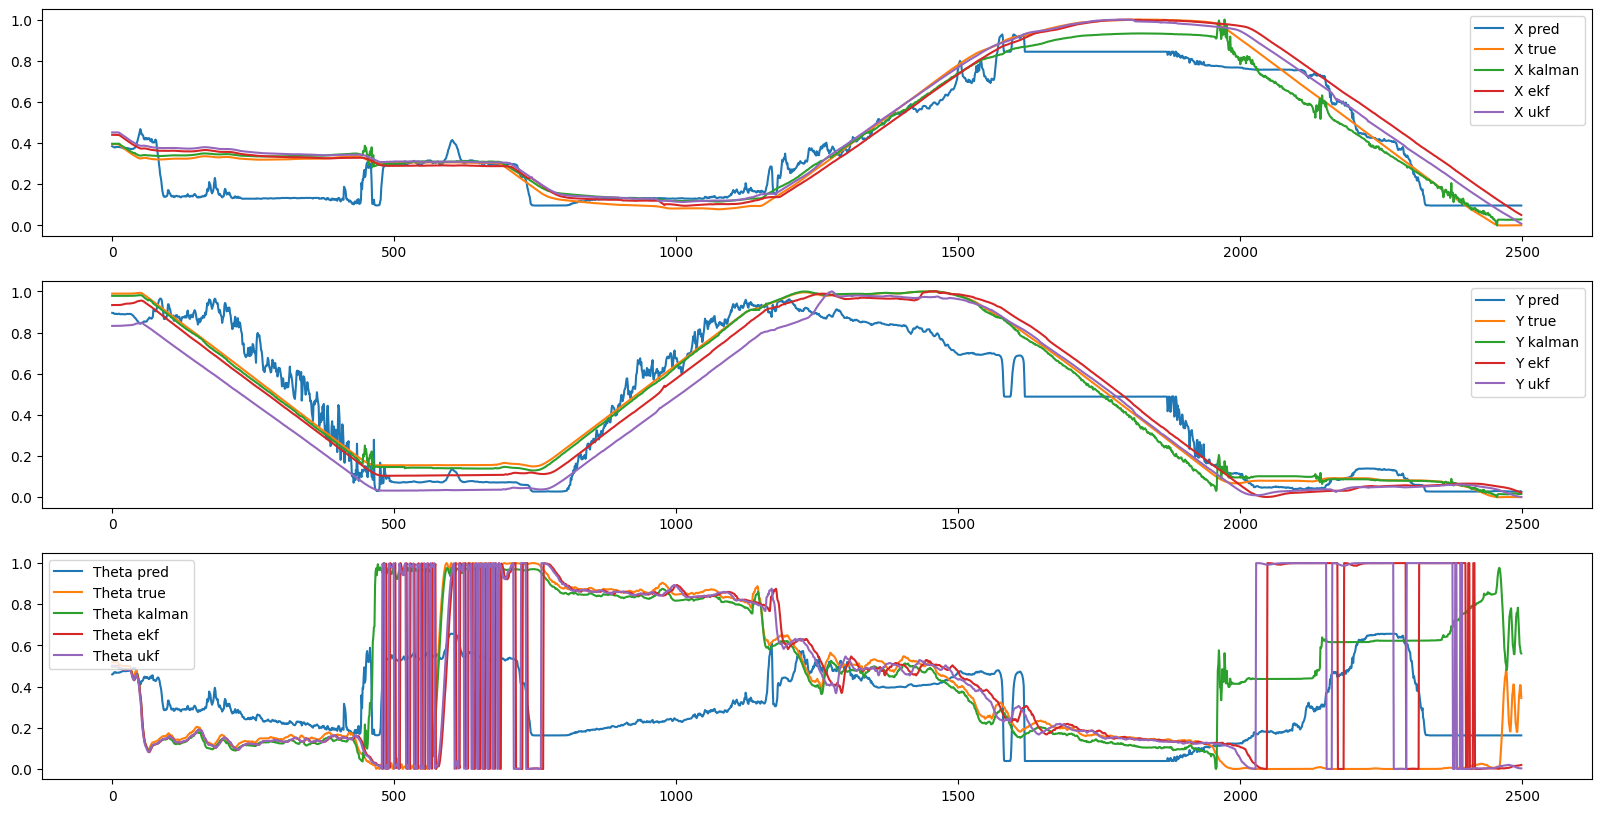

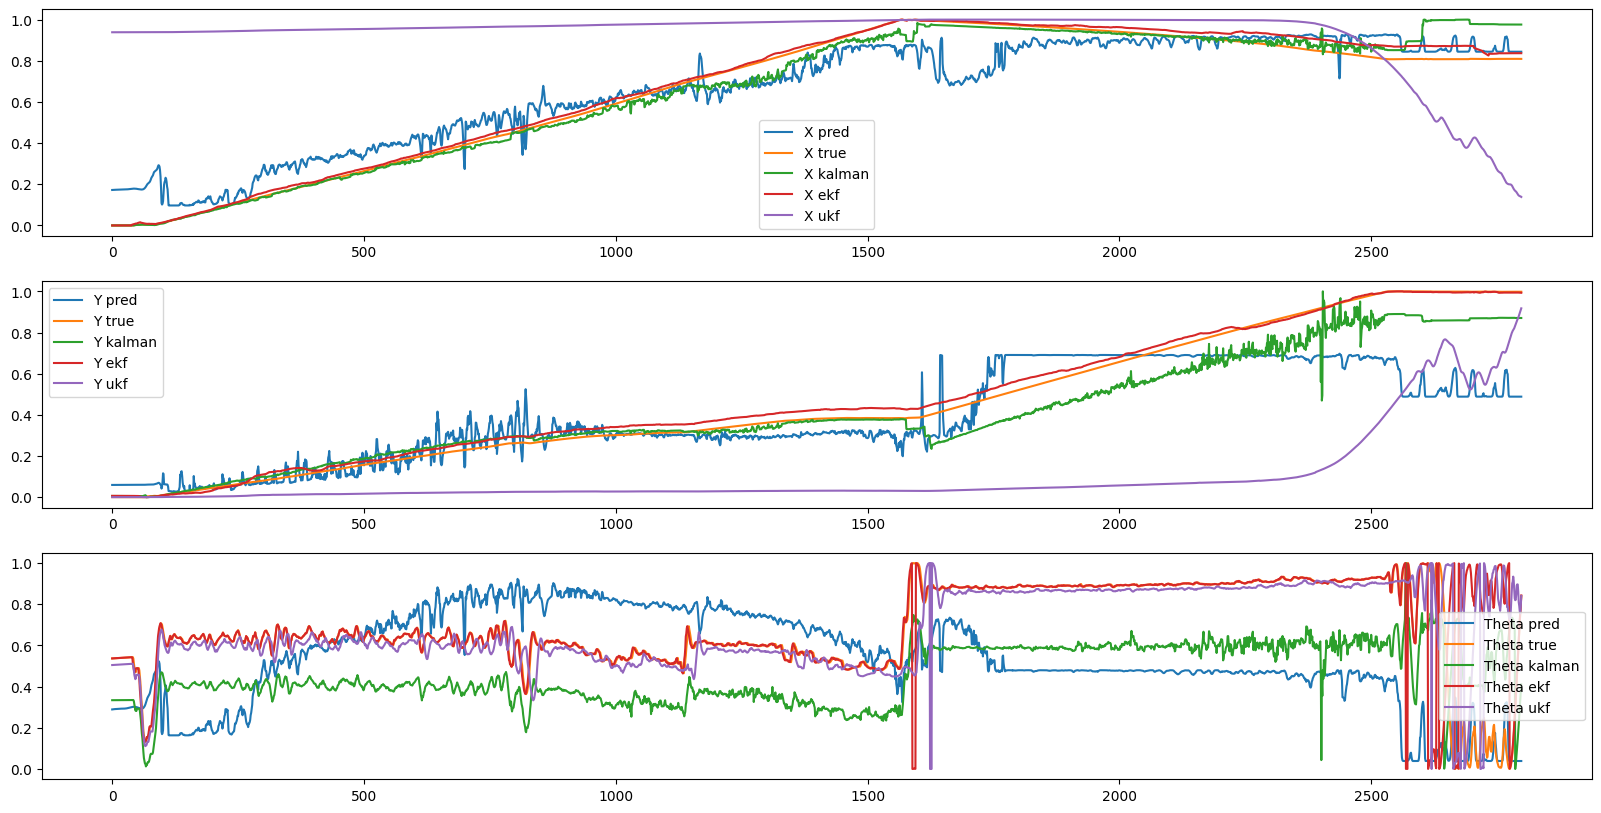

In [21]:
data_dim = 2
model_name = "LSTM"
params, test_set_name = test_setup(data_dim=2, model_name=model_name)

lstm_2d_results_df = get_results(params, test_set_name, model_name=model_name)
# save_results(lstm_2d_results_df, model_name=model_name, data_dim=data_dim)

## RNN

config: {'dir': 'logs/appended_mae/experiments_2D/model_best_RNN.pth', 'dir_2': '/home/rufael.marew/ray_results/train_ray_2023-05-07_19-59-20/train_ray_22a6a_00010_10_hidden_size=16,lr=0.0003,num_layers=12,sequence_length=14_2023-05-07_20-11-43', 'hidden_size': 16, 'lr': 0.00030107987499436694, 'metric': 0.13527004569768905, 'num_layers': 12, 'sequence_length': 14, 'batch_size': 100, 'model_name': 'RNN', 'input_size': 19, 'output_size': 3, 'data_dim': 2, 'json_config_path': './logs/appended_mae/experiments_2D/best_config_RNN.json', 'plot_limit': -1, 'save_plots': True, 'save_dir': './results/2D/RNN/plots', 'eval_dir_path': 'data/2D/evaluation_data', 'loss': 'mae', 'save_name': 'fbcampus_alpha_8_run_2_merged'}
Loading RNN model...
Test loss: 0.14165683072060348
config: {'dir': 'logs/appended_mae/experiments_2D/model_best_RNN.pth', 'dir_2': '/home/rufael.marew/ray_results/train_ray_2023-05-07_19-59-20/train_ray_22a6a_00010_10_hidden_size=16,lr=0.0003,num_layers=12,sequence_length=14_2023

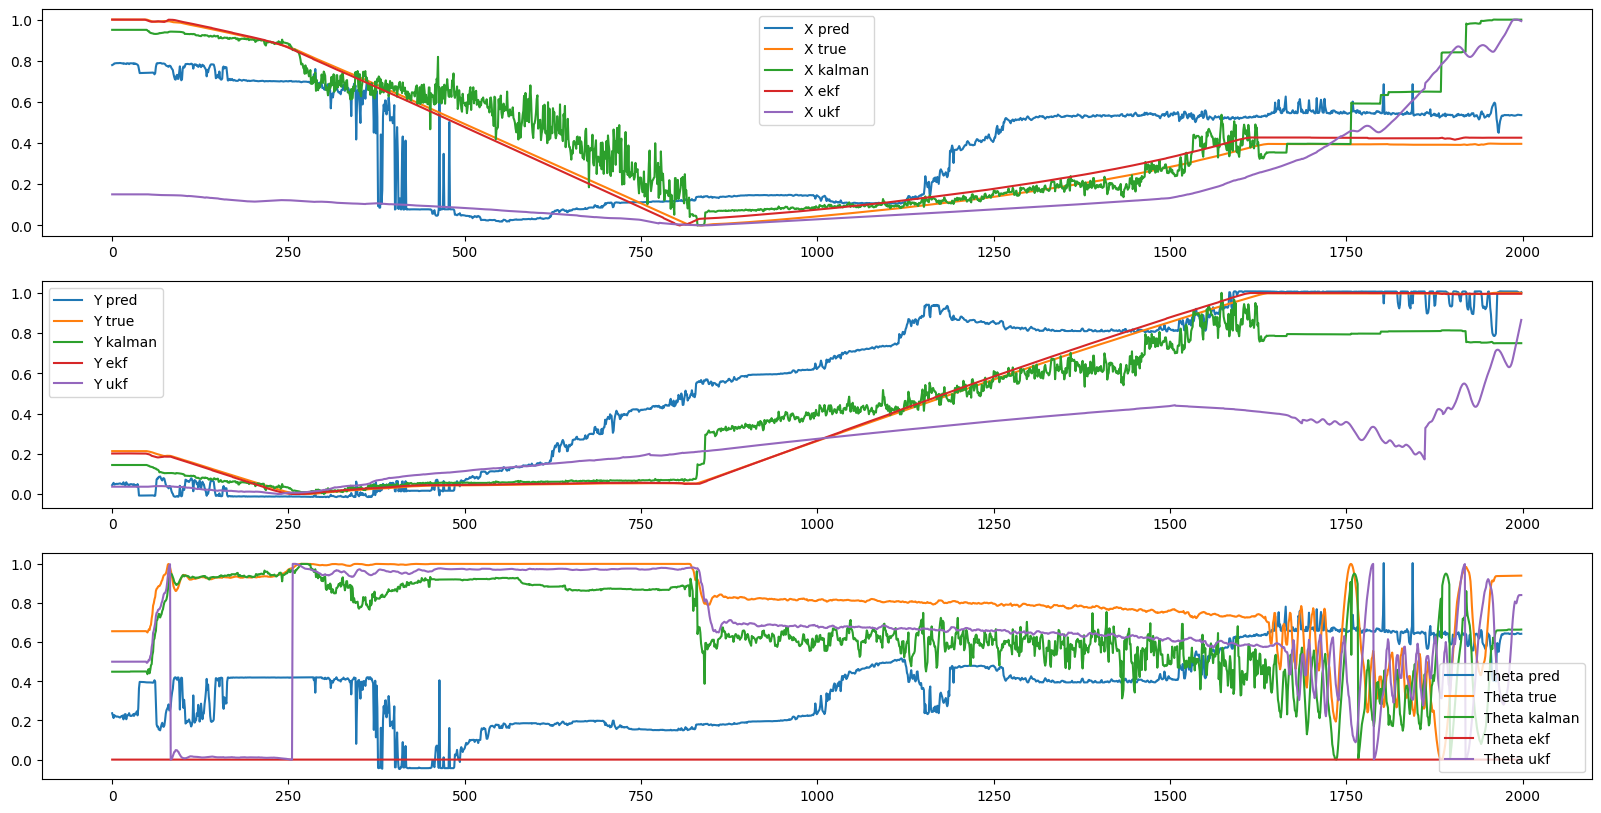

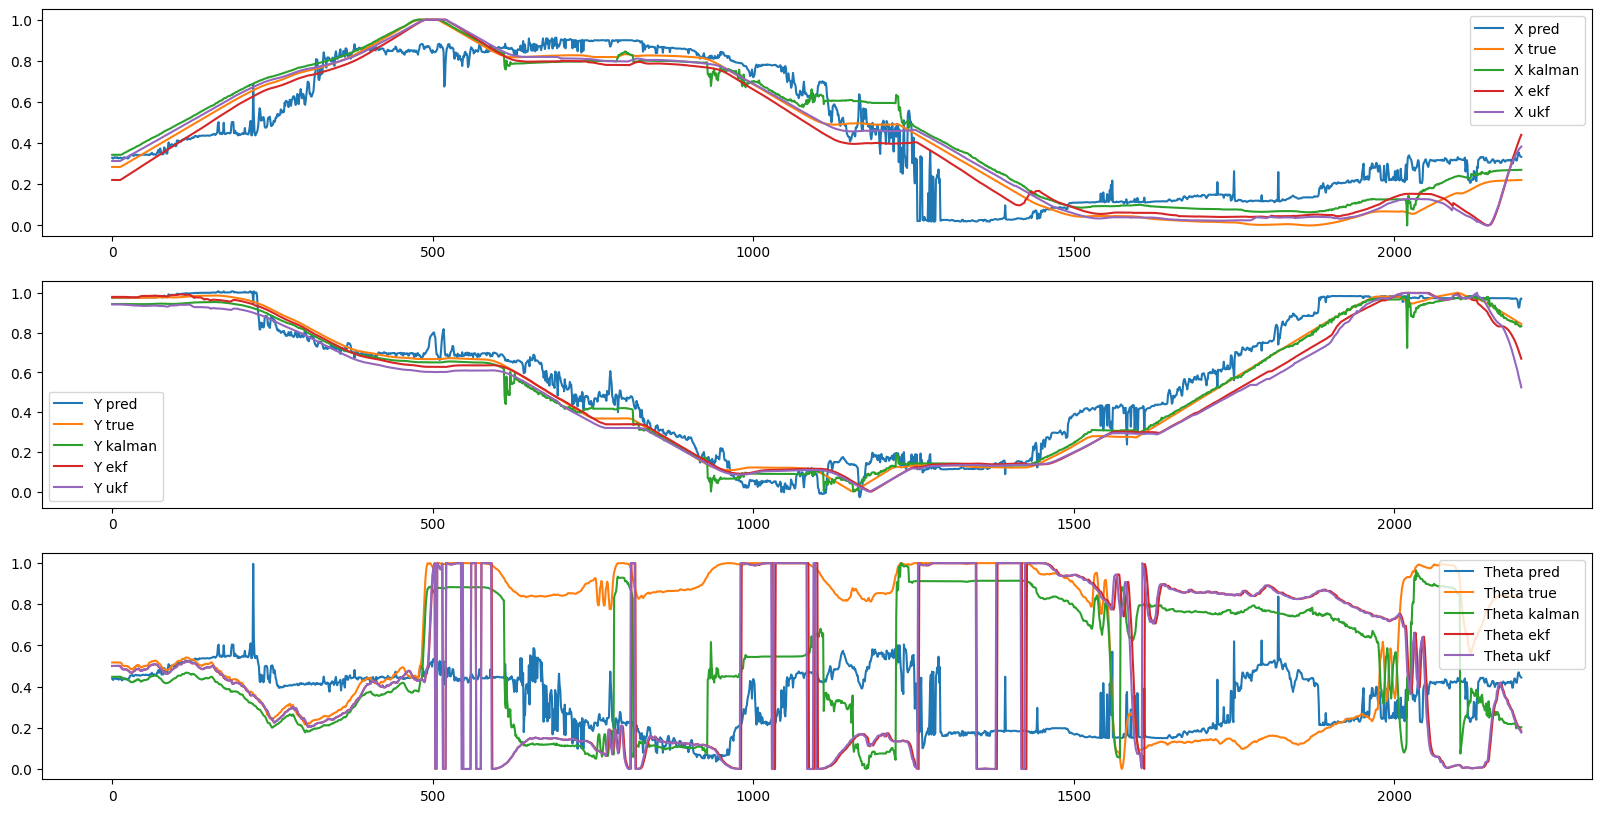

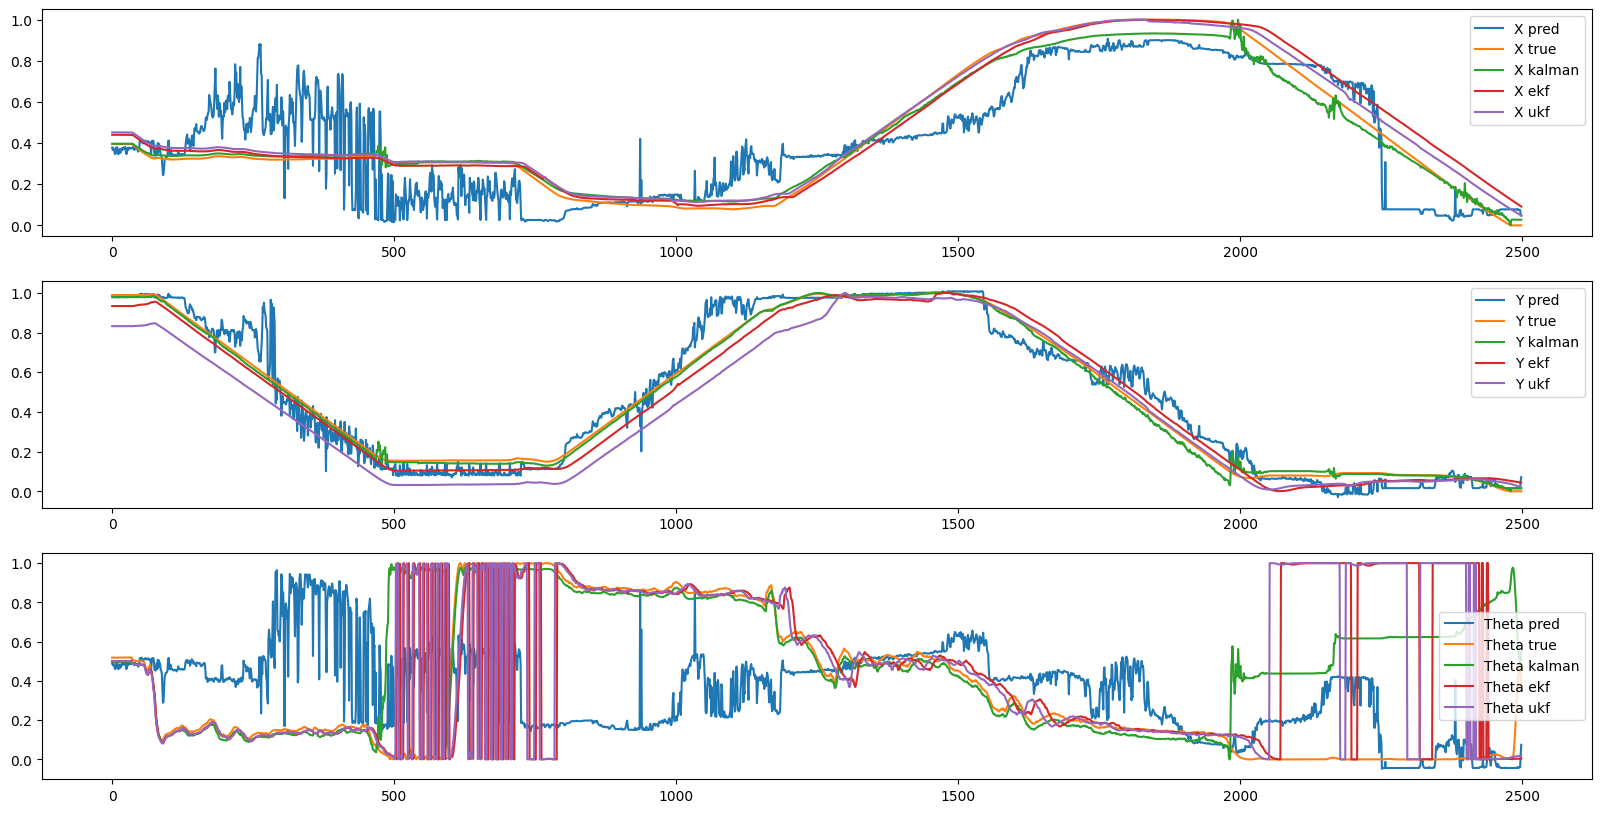

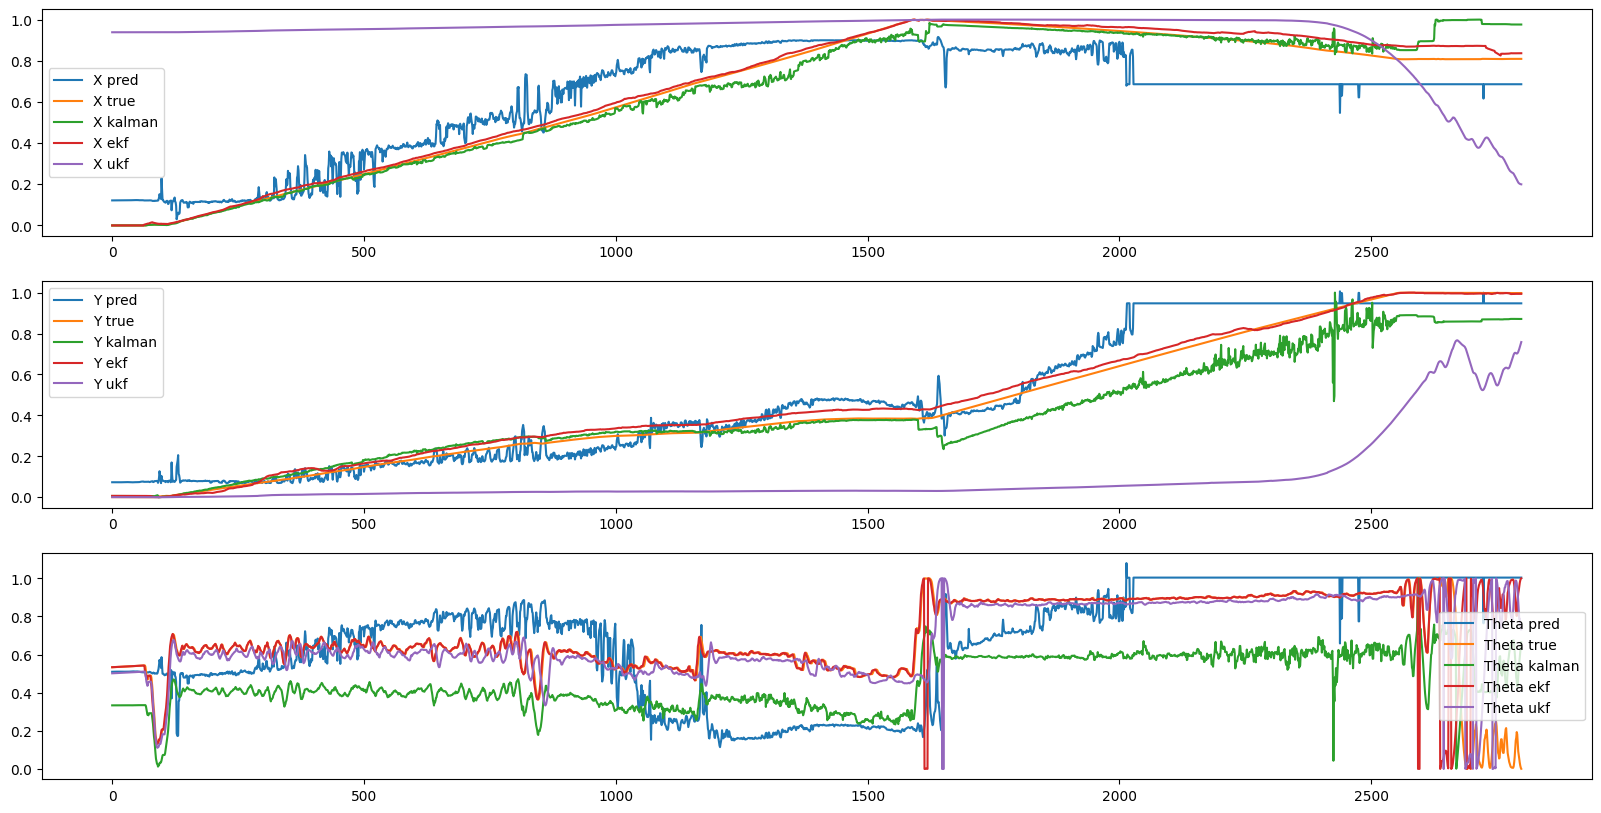

In [22]:
data_dim = 2
model_name = "RNN"
params, test_set_name = test_setup(data_dim=2, model_name=model_name)
# params, test_set_name = test_setup(data_dim=2, model_name=model_name, dataset='generated_data_fbcampus_alpha_4')
rnn_2d_results_df = get_results(params, test_set_name, model_name=model_name)
# save_results(rnn_2d_results_df, model_name=model_name, data_dim=data_dim)

## GRU

config: {'dir': '/home/rufael.marew/ray_results/train_ray_2023-05-11_05-32-13/train_ray_a9ec7_00012_12_hidden_size=8,lr=0.0006,num_layers=4,sequence_length=38_2023-05-11_07-22-17', 'hidden_size': 8, 'lr': 0.0006228948467349188, 'metric': 0.1073008798635923, 'num_layers': 4, 'sequence_length': 38, 'batch_size': 100, 'model_name': 'GRU', 'input_size': 19, 'output_size': 3, 'data_dim': 2, 'json_config_path': './logs/appended_mae/experiments_2D/best_config_GRU.json', 'plot_limit': -1, 'save_plots': True, 'save_dir': './results/2D/GRU/plots', 'eval_dir_path': 'data/2D/evaluation_data', 'loss': 'mae', 'save_name': 'fbcampus_alpha_8_run_2_merged'}
Loading GRU model...
Test loss: 0.20177514380530306
config: {'dir': '/home/rufael.marew/ray_results/train_ray_2023-05-11_05-32-13/train_ray_a9ec7_00012_12_hidden_size=8,lr=0.0006,num_layers=4,sequence_length=38_2023-05-11_07-22-17', 'hidden_size': 8, 'lr': 0.0006228948467349188, 'metric': 0.1073008798635923, 'num_layers': 4, 'sequence_length': 38, '

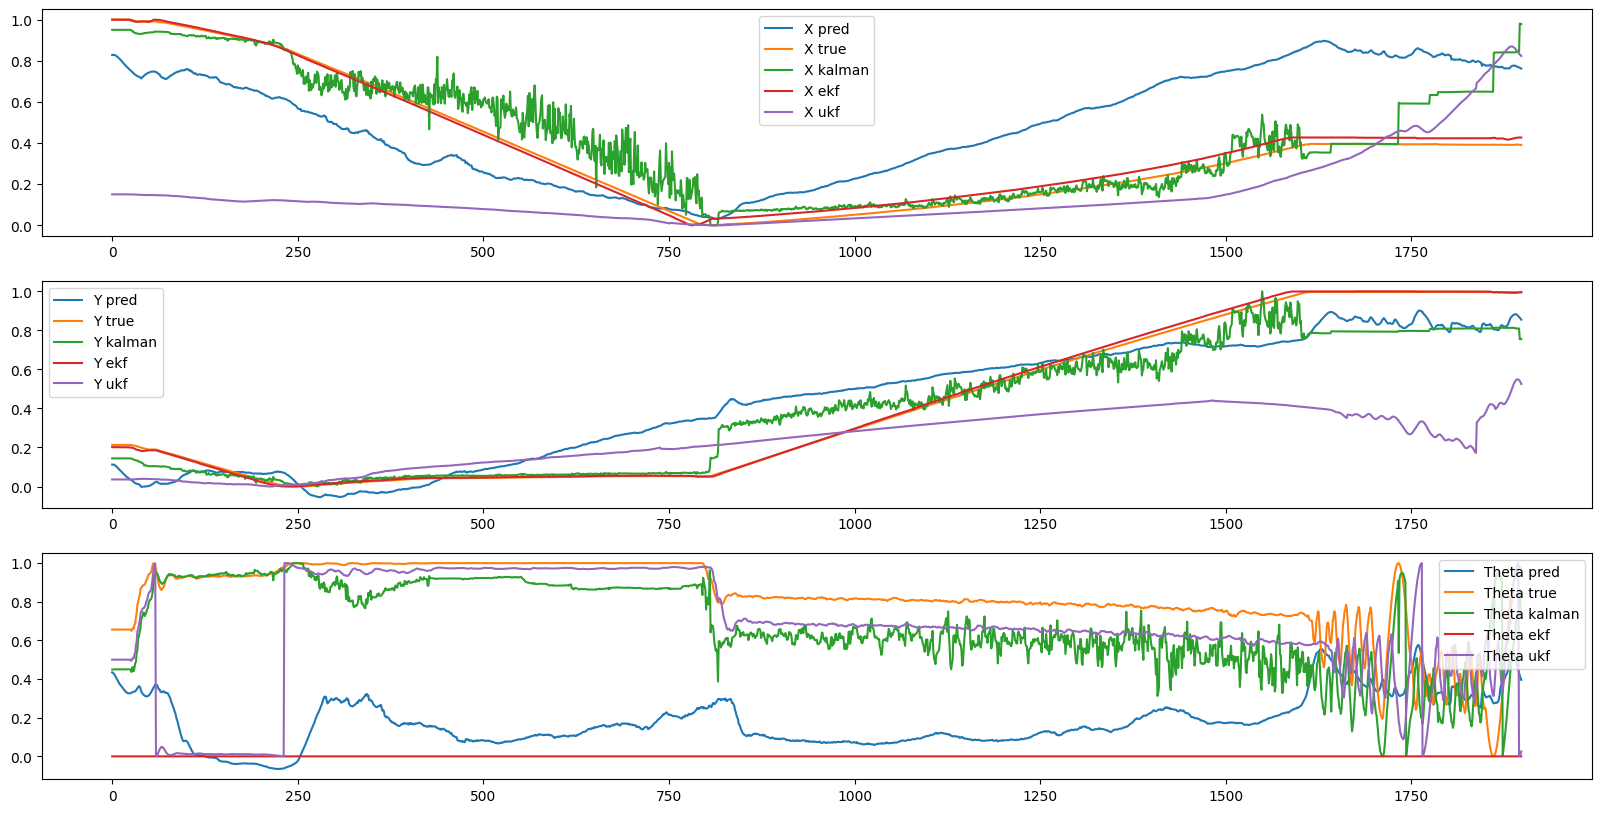

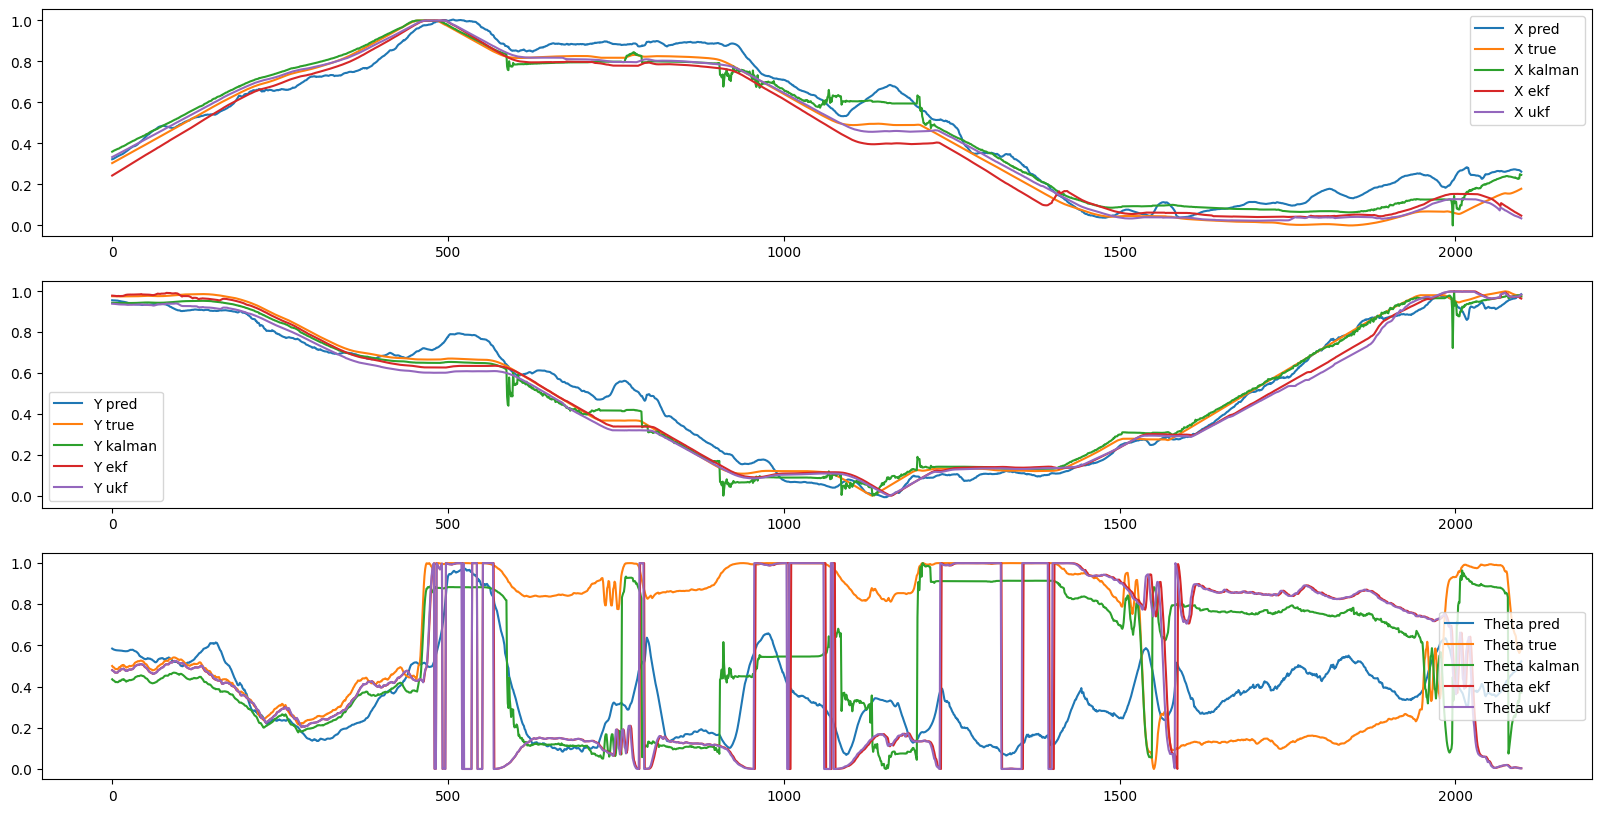

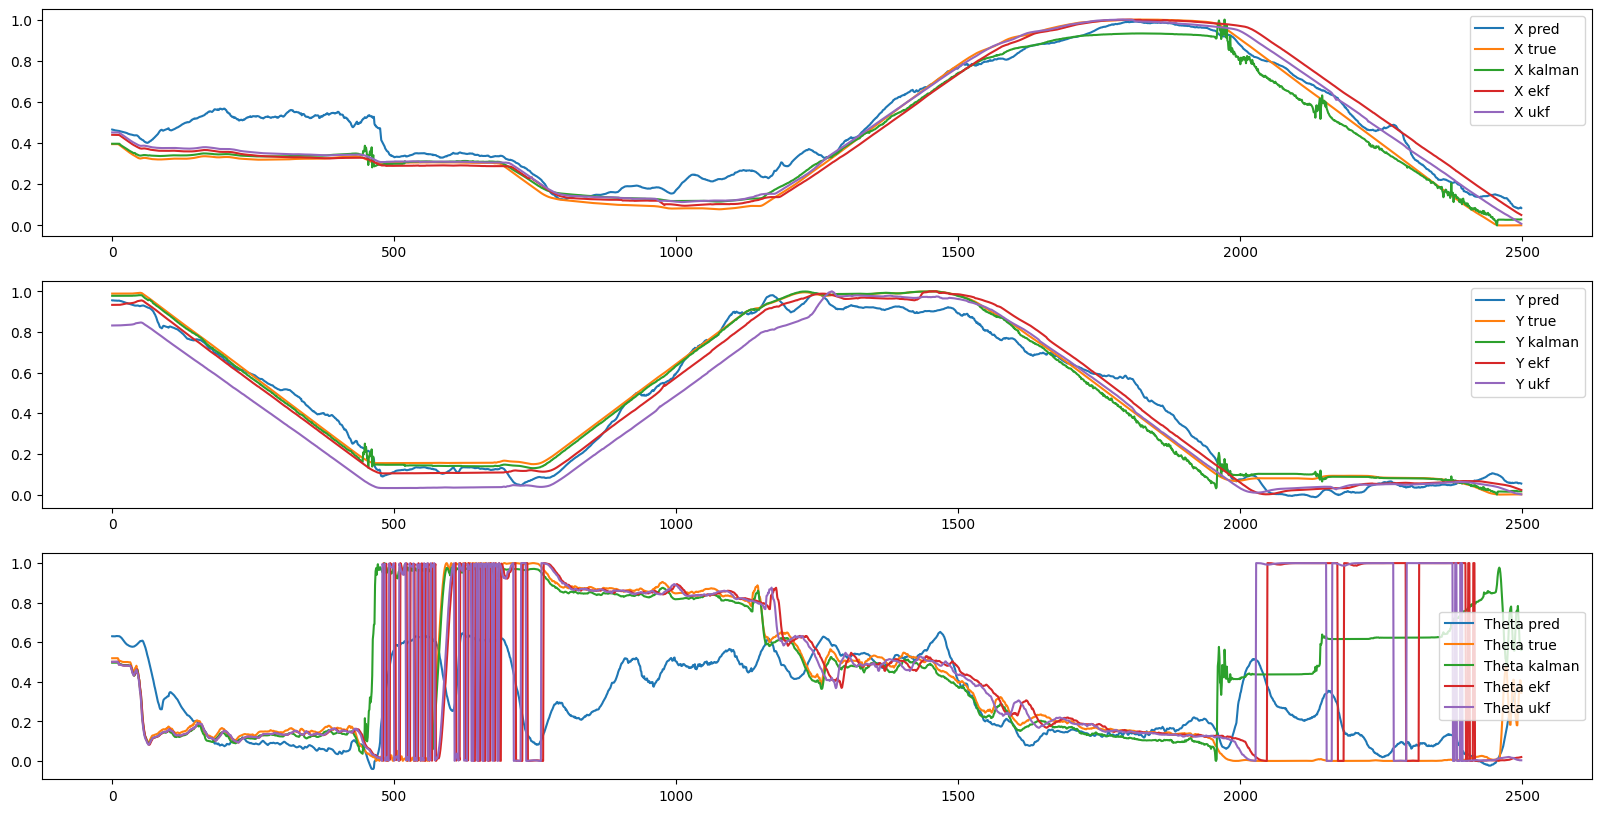

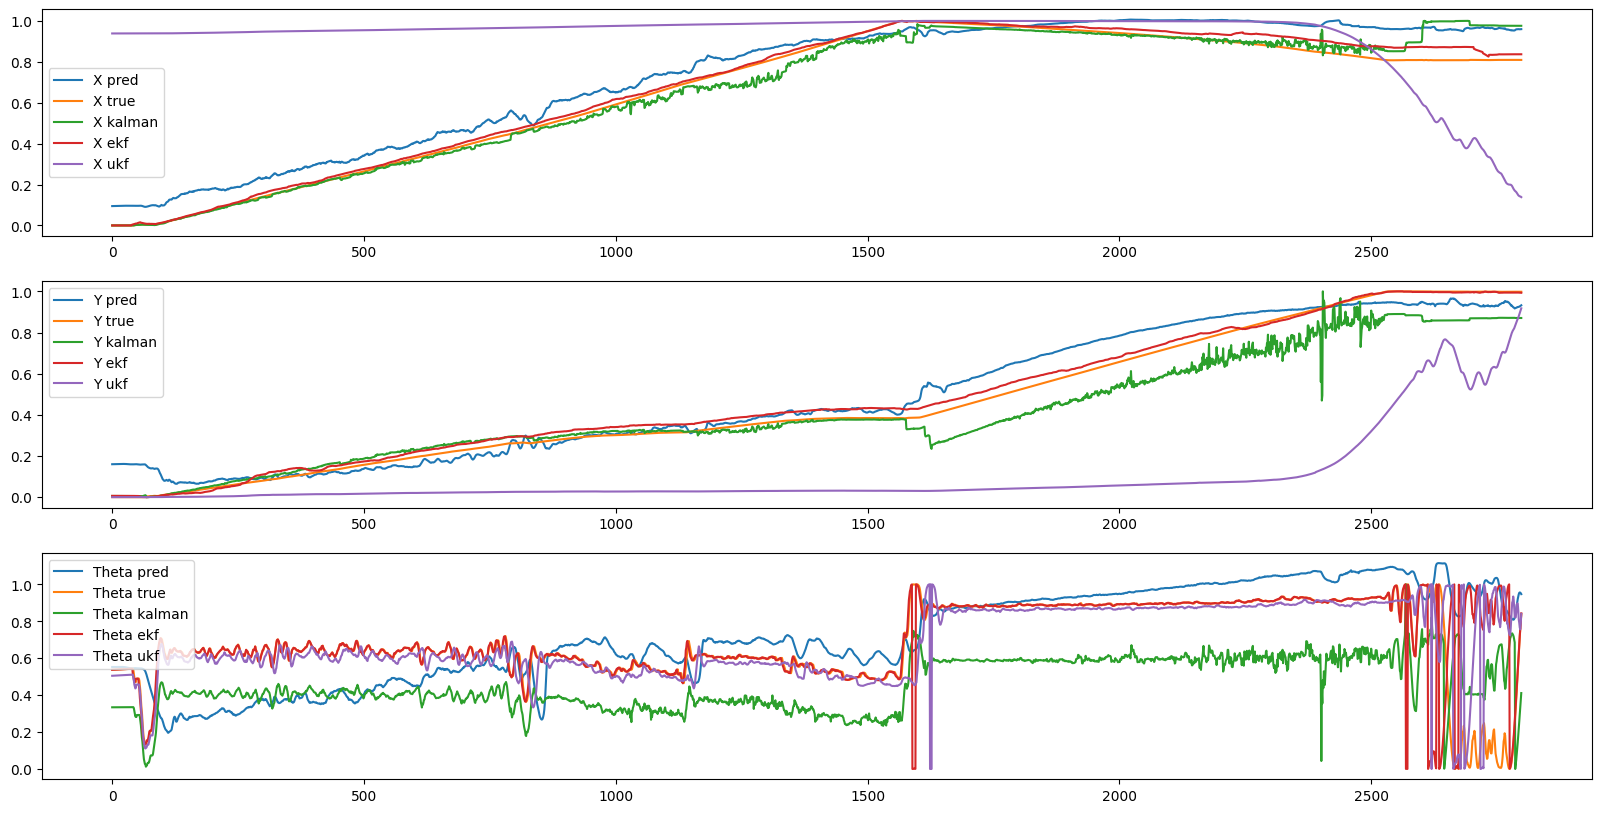

In [23]:
data_dim = 2
model_name = "GRU"
params, test_set_name = test_setup(data_dim=2, model_name=model_name)
gru_2d_results_df = get_results(params, test_set_name, model_name=model_name)
# save_results(gru_2d_results_df, model_name=model_name, data_dim=data_dim)

## Compiling Results

In [156]:
df = lstm_2d_results_df.copy().set_index(["Test set"])
alpha_dict = dict(zip(
    ['Intel 1', 'FB Campus 1', 'FB Campus 2', 'Intel 2'],
    [str(i) for i in [8, 4, 8, 4]]
))

df.columns
# df['Test set']


Index(['Test model', 'Kalman MAE', 'NN MAE', 'EKF MAE', 'UKF MAE',
       'Kalman MAE X', 'NN MAE X', 'EKF MAE X', 'UKF MAE X', 'Kalman MAE Y',
       'NN MAE Y', 'EKF MAE Y', 'UKF MAE Y', 'Kalman MAE Theta',
       'NN MAE Theta', 'EKF MAE Theta', 'UKF MAE Theta'],
      dtype='object')

In [157]:
# overall_cols = ['Test set', 'Test model', 'Alpha', 'Kalman MAE', 'NN MAE', 'EKF MAE', 'UKF MAE']
# x_dim_cols = ['Test set', 'Test model', 'Alpha', 'Kalman MAE X', 'NN MAE X', 'EKF MAE X', 'UKF MAE X']
# y_dim_cols = ['Test set', 'Test model', 'Alpha', 'Kalman MAE Y', 'NN MAE Y', 'EKF MAE Y', 'UKF MAE Y']
# theta_cols = ['Test set', 'Test model', 'Alpha', 'Kalman MAE Theta', 'NN MAE Theta', 'EKF MAE Theta', 'UKF MAE Theta']

# create 4 main df (overall, x, y, theta)

overall_cols = [ 'Kalman MAE', 'NN MAE', 'EKF MAE', 'UKF MAE']
x_dim_cols = ['Kalman MAE X', 'NN MAE X', 'EKF MAE X', 'UKF MAE X']
y_dim_cols = ['Kalman MAE Y', 'NN MAE Y', 'EKF MAE Y', 'UKF MAE Y']
theta_cols = ['Kalman MAE Theta', 'NN MAE Theta', 'EKF MAE Theta', 'UKF MAE Theta']


overall_results_df = df[overall_cols].rename(columns={"NN MAE": "LSTM MAE"})
x_results_df = df[x_dim_cols].rename(columns={"NN MAE X": "LSTM MAE X"})
y_results_df = df[y_dim_cols].rename(columns={"NN MAE Y": "LSTM MAE Y"})
theta_results_df = df[theta_cols].rename(columns={"NN MAE Theta": "LSTM MAE Theta"})

In [158]:
# add cols to main DFs
overall_results_df['RNN MAE'] = rnn_2d_results_df.set_index(["Test set"])['NN MAE']
overall_results_df['LSTM MAE'] = lstm_2d_results_df.set_index(["Test set"])['NN MAE']
overall_results_df['GRU MAE'] = gru_2d_results_df.set_index(["Test set"])['NN MAE']
overall_results_df["LSTM LN MAE"] = lstm_ln_2d_results_df.set_index(["Test set"])['NN MAE']

overall_results_df = overall_results_df.reset_index()
overall_results_df['Alpha'] = overall_results_df.apply(lambda row: alpha_dict[row['Test set']], axis= 1)


x_results_df['RNN MAE X'] = rnn_2d_results_df.set_index(["Test set"])['NN MAE X']
x_results_df['LSTM MAE X'] = lstm_2d_results_df.set_index(["Test set"])['NN MAE X']
x_results_df['GRU MAE X'] = gru_2d_results_df.set_index(["Test set"])['NN MAE X']
x_results_df["LSTM LN MAE X"] = lstm_ln_2d_results_df.set_index(["Test set"])['NN MAE X']

x_results_df = x_results_df.reset_index()
x_results_df['Alpha'] = x_results_df.apply(lambda row: alpha_dict[row['Test set']], axis= 1)


y_results_df['RNN MAE Y'] = rnn_2d_results_df.set_index(["Test set"])['NN MAE Y']
y_results_df['LSTM MAE Y'] = lstm_2d_results_df.set_index(["Test set"])['NN MAE Y']
y_results_df['GRU MAE Y'] = gru_2d_results_df.set_index(["Test set"])['NN MAE Y']
y_results_df["LSTM LN MAE Y"] = lstm_ln_2d_results_df.set_index(["Test set"])['NN MAE Y']

y_results_df = y_results_df.reset_index()
y_results_df['Alpha'] = y_results_df.apply(lambda row: alpha_dict[row['Test set']], axis= 1)


theta_results_df['RNN MAE Theta'] = rnn_2d_results_df.set_index(["Test set"])['NN MAE Theta']
theta_results_df['LSTM MAE Theta'] = lstm_2d_results_df.set_index(["Test set"])['NN MAE Theta']
theta_results_df['GRU MAE Theta'] = gru_2d_results_df.set_index(["Test set"])['NN MAE Theta']
theta_results_df["LSTM LN MAE Theta"] = lstm_ln_2d_results_df.set_index(["Test set"])['NN MAE Theta']

theta_results_df = theta_results_df.reset_index()
theta_results_df['Alpha'] = theta_results_df.apply(lambda row: alpha_dict[row['Test set']], axis= 1)

In [159]:
# # çy_results_df["Test set"].apply(lambda x: x.split(" ")[:-1])
# def reshape(y_results_df):
#     y_results_df["Environments"] = y_results_df["Test set"].apply(lambda x: " ".join(x.split(" ")[:-1]))
#     return y_results_df.sort_values(by=['Environments','Alpha'])[['Environments', 'Alpha',  'Kalman MAE Y', 'LSTM MAE Y', 'EKF MAE Y', 'UKF MAE Y','RNN MAE Y', 'GRU MAE Y']].round(3)

overall_results_df["Environments"] = overall_results_df["Test set"].apply(lambda x: " ".join(x.split(" ")[:-1]))
overall_results_df = overall_results_df.sort_values(by=['Environments','Alpha'])[['Environments', 'Alpha',  'Kalman MAE', 'LSTM LN MAE', 'LSTM MAE', 'EKF MAE', 'UKF MAE','RNN MAE', 'GRU MAE']].round(3)

x_results_df["Environments"] = x_results_df["Test set"].apply(lambda x: " ".join(x.split(" ")[:-1]))
x_results_df = x_results_df.sort_values(by=['Environments','Alpha'])[['Environments', 'Alpha',  'Kalman MAE X', 'LSTM LN MAE X',  'LSTM MAE X', 'EKF MAE X', 'UKF MAE X','RNN MAE X', 'GRU MAE X']].round(3)

y_results_df["Environments"] = y_results_df["Test set"].apply(lambda x: " ".join(x.split(" ")[:-1]))
y_results_df = y_results_df.sort_values(by=['Environments','Alpha'])[['Environments', 'Alpha',  'Kalman MAE Y', 'LSTM LN MAE Y', 'LSTM MAE Y', 'EKF MAE Y', 'UKF MAE Y','RNN MAE Y', 'GRU MAE Y']].round(3)

theta_results_df["Environments"] = theta_results_df["Test set"].apply(lambda x: " ".join(x.split(" ")[:-1]))
theta_results_df = theta_results_df.sort_values(by=['Environments','Alpha'])[['Environments', 'Alpha',  'Kalman MAE Theta', 'LSTM LN MAE Theta', 'LSTM MAE Theta', 'EKF MAE Theta', 'UKF MAE Theta','RNN MAE Theta', 'GRU MAE Theta']].round(3)

In [160]:
print(overall_results_df.transpose().to_latex())

\begin{tabular}{lllll}
\toprule
 & 3 & 0 & 2 & 1 \\
\midrule
Environments & FB Campus & FB Campus & Intel & Intel \\
Alpha & 4 & 8 & 4 & 8 \\
Kalman MAE & 0.034000 & 0.079000 & 0.033000 & 0.044000 \\
LSTM LN MAE & 0.073000 & 0.163000 & 0.101000 & 0.057000 \\
LSTM MAE & 0.083000 & 0.233000 & 0.086000 & 0.082000 \\
EKF MAE & 0.020000 & 0.026000 & 0.039000 & 0.038000 \\
UKF MAE & 0.339000 & 0.260000 & 0.030000 & 0.019000 \\
RNN MAE & 0.120000 & 0.197000 & 0.135000 & 0.104000 \\
GRU MAE & 0.082000 & 0.269000 & 0.081000 & 0.073000 \\
\bottomrule
\end{tabular}



In [161]:
print(x_results_df.transpose().to_latex())

\begin{tabular}{lllll}
\toprule
 & 3 & 0 & 2 & 1 \\
\midrule
Environments & FB Campus & FB Campus & Intel & Intel \\
Alpha & 4 & 8 & 4 & 8 \\
Kalman MAE X & 0.034000 & 0.079000 & 0.033000 & 0.044000 \\
LSTM LN MAE X & 0.073000 & 0.163000 & 0.101000 & 0.057000 \\
LSTM MAE X & 0.083000 & 0.233000 & 0.086000 & 0.082000 \\
EKF MAE X & 0.020000 & 0.026000 & 0.039000 & 0.038000 \\
UKF MAE X & 0.339000 & 0.260000 & 0.030000 & 0.019000 \\
RNN MAE X & 0.120000 & 0.197000 & 0.135000 & 0.104000 \\
GRU MAE X & 0.082000 & 0.269000 & 0.081000 & 0.073000 \\
\bottomrule
\end{tabular}



In [162]:
print(y_results_df.transpose().to_latex())


\begin{tabular}{lllll}
\toprule
 & 3 & 0 & 2 & 1 \\
\midrule
Environments & FB Campus & FB Campus & Intel & Intel \\
Alpha & 4 & 8 & 4 & 8 \\
Kalman MAE Y & 0.065000 & 0.080000 & 0.014000 & 0.021000 \\
LSTM LN MAE Y & 0.091000 & 0.132000 & 0.066000 & 0.052000 \\
LSTM MAE Y & 0.115000 & 0.202000 & 0.093000 & 0.068000 \\
EKF MAE Y & 0.025000 & 0.008000 & 0.042000 & 0.026000 \\
UKF MAE Y & 0.357000 & 0.233000 & 0.078000 & 0.039000 \\
RNN MAE Y & 0.064000 & 0.158000 & 0.057000 & 0.058000 \\
GRU MAE Y & 0.056000 & 0.133000 & 0.056000 & 0.049000 \\
\bottomrule
\end{tabular}



In [163]:
print(theta_results_df.transpose().to_latex())

\begin{tabular}{lllll}
\toprule
 & 3 & 0 & 2 & 1 \\
\midrule
Environments & FB Campus & FB Campus & Intel & Intel \\
Alpha & 4 & 8 & 4 & 8 \\
Kalman MAE Theta & 0.267000 & 0.167000 & 0.184000 & 0.342000 \\
LSTM LN MAE Theta & 0.137000 & 0.703000 & 0.125000 & 0.513000 \\
LSTM MAE Theta & 0.286000 & 0.516000 & 0.278000 & 0.376000 \\
EKF MAE Theta & 0.050000 & 0.824000 & 0.214000 & 0.423000 \\
UKF MAE Theta & 0.071000 & 0.189000 & 0.209000 & 0.423000 \\
RNN MAE Theta & 0.203000 & 0.506000 & 0.295000 & 0.399000 \\
GRU MAE Theta & 0.166000 & 0.655000 & 0.203000 & 0.409000 \\
\bottomrule
\end{tabular}



In [164]:
table_path = "output/tables/"

overall_results_df.T.to_latex(os.path.join(table_path , "results_2D_combined_overall.tex"), index=True)
x_results_df.T.to_latex(os.path.join(table_path , "results_2D_combined_x.tex"), index=True)
y_results_df.T.to_latex(os.path.join(table_path , "results_2D_combined_y.tex"), index=True)
theta_results_df.T.to_latex(os.path.join(table_path , "results_2D_combined_theta.tex"), index=True)

In [33]:
def bar_plot(cfg, df):
    # if cfg.DATA.SETTING == '2D':
    #     df_plot = df[['RNN','LSTM','GRU','KF','EKF','UKF']]
    #     df_plot.index = df['Environment']

    #     df_plot.plot(kind="bar",figsize=(15, 8))
    #     plt.title('Total MAE')
    #     plt.ylabel('MAE')
    #     plt.xlabel('Environment')
    #     plt.xticks(rotation=0)
    #     plt.legend(loc='upper right')

    #     os.makedirs(os.path.join('output','figures'), exist_ok=True)
    #     plt.savefig(os.path.join('output','figures','{}_{}.png'.format(cfg.DATA.SETTING, cfg.DATA.SETUP)))
    df_plot = df[['RNN MAE','LSTM MAE','Kalman MAE',]]
    df_plot.index = df['Test set']

    df_plot.plot(kind="bar",figsize=(15, 8))
    plt.title('Total MAE')
    plt.ylabel('MAE')
    plt.xlabel('Environment')
    plt.xticks(rotation=0)
    plt.legend(loc='upper right')

    os.makedirs(os.path.join('output','figures'), exist_ok=True)
    plt.show()
    # plt.savefig(os.path.join('output','figures','{}_{}.png'.format(cfg.DATA.SETTING, cfg.DATA.SETUP)))


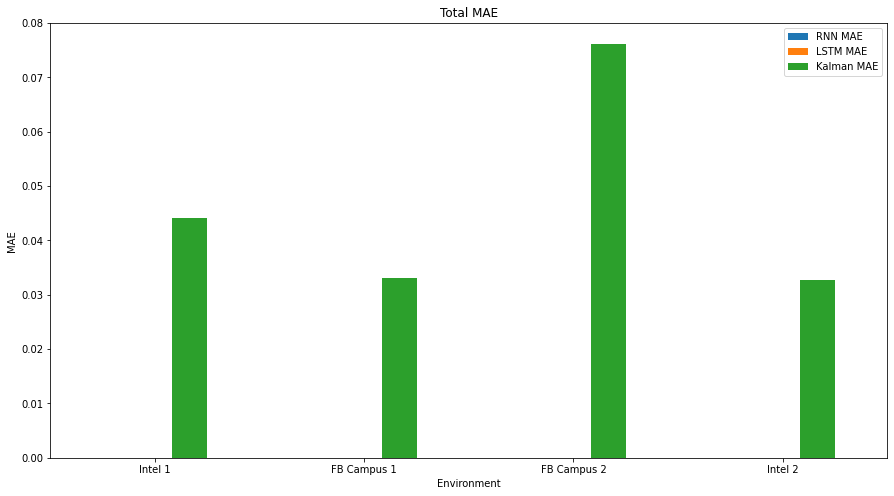

In [35]:
bar_plot({}, overall_results_df)

# 1D Results

## LSTM

In [14]:
params

{'batch_size': 20,
 'model_name': 'LSTM',
 'input_size': 9,
 'output_size': 1,
 'data_dim': 1,
 'json_config_path': './logs/appended_mae/experiments_1D/best_config_LSTM.json',
 'plot_limit': -1,
 'save_plots': True,
 'save_dir': './results/1D/LSTM/plots',
 'eval_dir_path': 'data/1D/evaluation_data',
 'loss': 'mae',
 'save_name': 'mnst_2_lnstd_1'}

config: {'dir': '/home/anees.hashmi/ray_results/train_ray_2023-05-07_20-05-07/train_ray_f2661_00012_12_hidden_size=256,lr=0.0002,num_layers=4,sequence_length=28_2023-05-07_20-09-26', 'hidden_size': 256, 'lr': 0.0001550194864416878, 'metric': 0.07533156732097268, 'num_layers': 4, 'sequence_length': 28, 'batch_size': 20, 'model_name': 'LSTM', 'input_size': 9, 'output_size': 1, 'data_dim': 1, 'json_config_path': './logs/appended_mae/experiments_1D/best_config_LSTM.json', 'plot_limit': -1, 'save_plots': True, 'save_dir': './results/1D/LSTM/plots', 'eval_dir_path': 'data/1D/evaluation_data', 'loss': 'mae', 'save_name': 'mnst_2_lnstd_1'}
Loading LSTM model...
len test loader: 3
Test loss: 0.017810223624110222
Test dataset shape: 3 and  (60, 28, 9)
NN MSE: 0.12249548934289116
KF MSE: 0.09688407135097012
config: {'dir': '/home/anees.hashmi/ray_results/train_ray_2023-05-07_20-05-07/train_ray_f2661_00012_12_hidden_size=256,lr=0.0002,num_layers=4,sequence_length=28_2023-05-07_20-09-26', 'hidden_s

Test set Test model  Kalman MAE    NN MAE
0   MNST 3       LSTM    0.096884  0.122495
1   MNST 2       LSTM    0.096437  0.101854
2   MNST 5       LSTM    0.107981  0.119655
3   MNST 0       LSTM    0.267766  0.149278
4   MNST 4       LSTM    0.095609  0.112537
5   MNST 1       LSTM    0.093884  0.105914

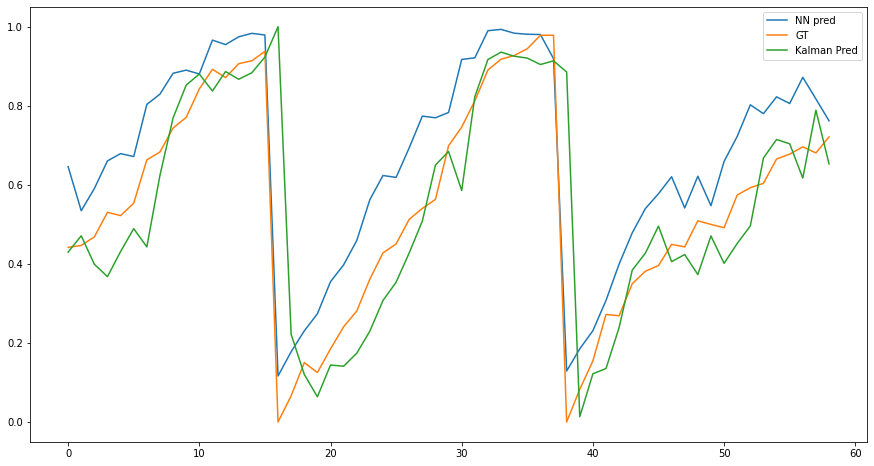

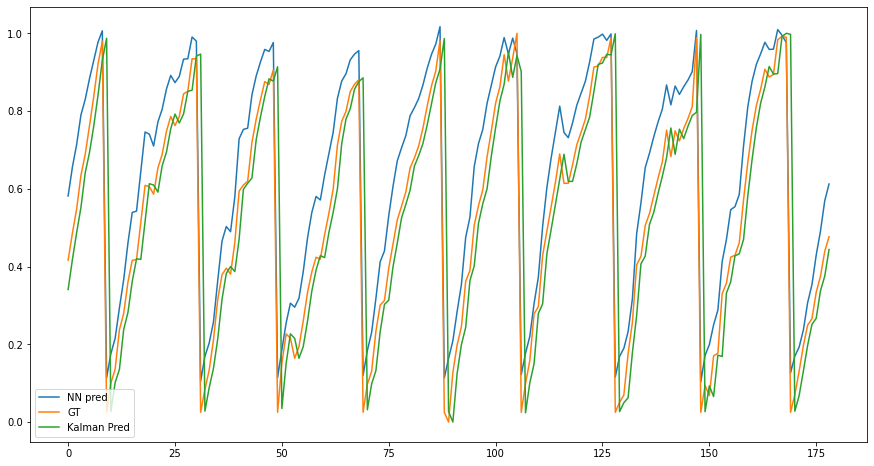

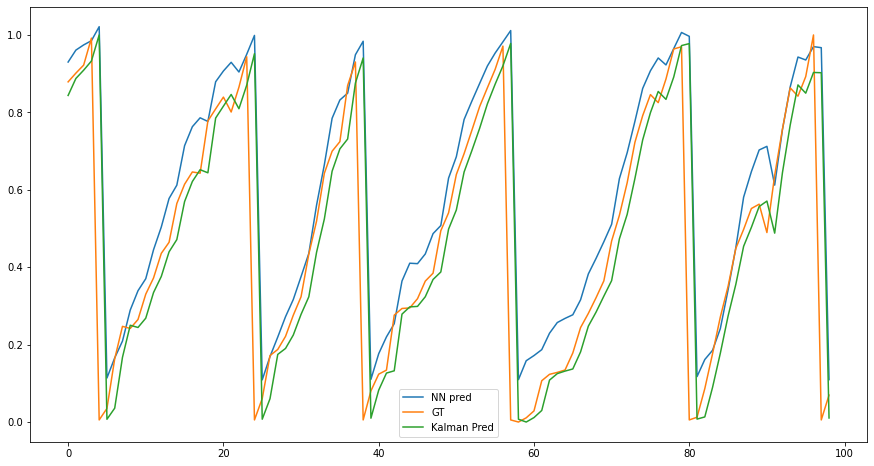

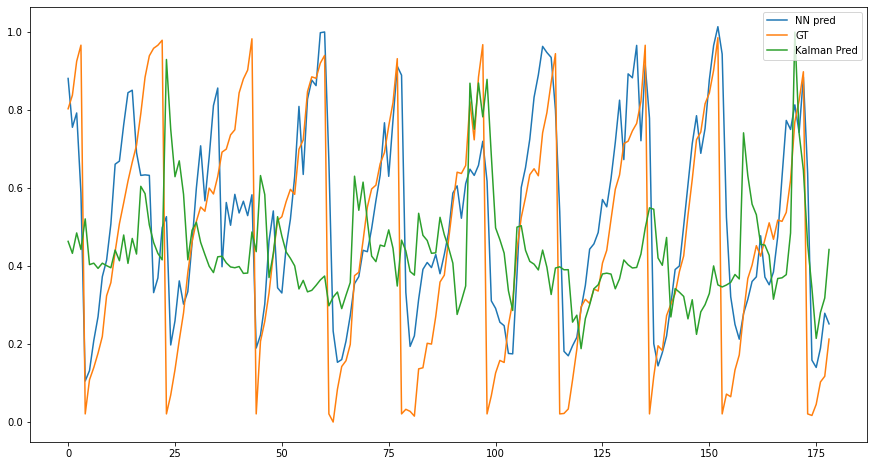

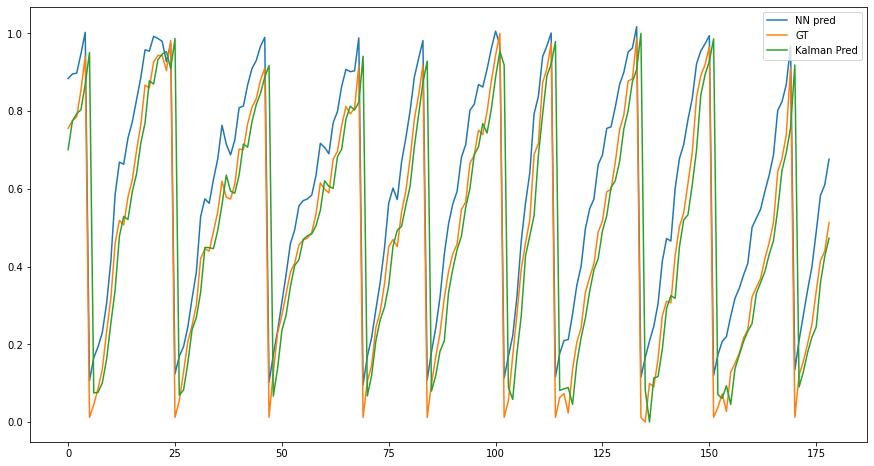

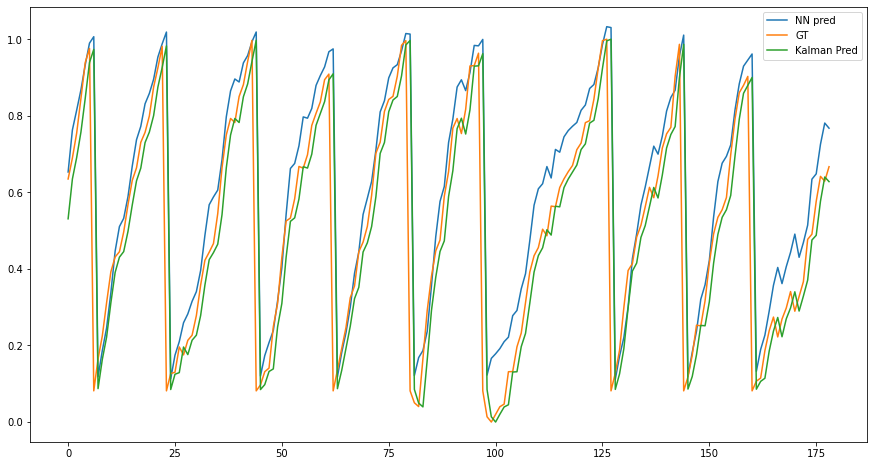

In [28]:
data_dim = 1
model_name = "LSTM"
params, test_set_name = test_setup(data_dim=1, model_name=model_name)
params['batch_size'] = 20
lstm_ln_1d_df = get_results(params, test_set_name, model_name=model_name, data_dim=data_dim)
save_results(lstm_ln_1d_df, data_dim=1, model_name=model_name)
lstm_ln_1d_df


## RNN

config: {'dir': '/home/anees.hashmi/ray_results/train_ray_2023-05-07_19-59-35/train_ray_2b636_00018_18_hidden_size=32,lr=0.0004,num_layers=4,sequence_length=14_2023-05-07_20-04-36', 'hidden_size': 32, 'lr': 0.00037683798844873116, 'metric': 0.09150242898613214, 'num_layers': 4, 'sequence_length': 14, 'batch_size': 20, 'model_name': 'RNN', 'input_size': 9, 'output_size': 1, 'data_dim': 1, 'json_config_path': './logs/appended_mae/experiments_1D/best_config_RNN.json', 'plot_limit': -1, 'save_plots': True, 'save_dir': './results/1D/RNN/plots', 'eval_dir_path': 'data/1D/evaluation_data', 'loss': 'mae', 'save_name': 'mnst_2_lnstd_1'}
Loading RNN model...
len test loader: 4
Test loss: 0.017873187083750963
Test dataset shape: 3 and  (80, 14, 9)
NN MSE: 0.1187132148305432
KF MSE: 0.1031715898417894
config: {'dir': '/home/anees.hashmi/ray_results/train_ray_2023-05-07_19-59-35/train_ray_2b636_00018_18_hidden_size=32,lr=0.0004,num_layers=4,sequence_length=14_2023-05-07_20-04-36', 'hidden_size': 32

Test set Test model  Kalman MAE    NN MAE
0   MNST 3        RNN    0.103172  0.118713
1   MNST 2        RNN    0.095816  0.098221
2   MNST 5        RNN    0.095942  0.110485
3   MNST 0        RNN    0.259670  0.160286
4   MNST 4        RNN    0.089686  0.107001
5   MNST 1        RNN    0.098370  0.100946

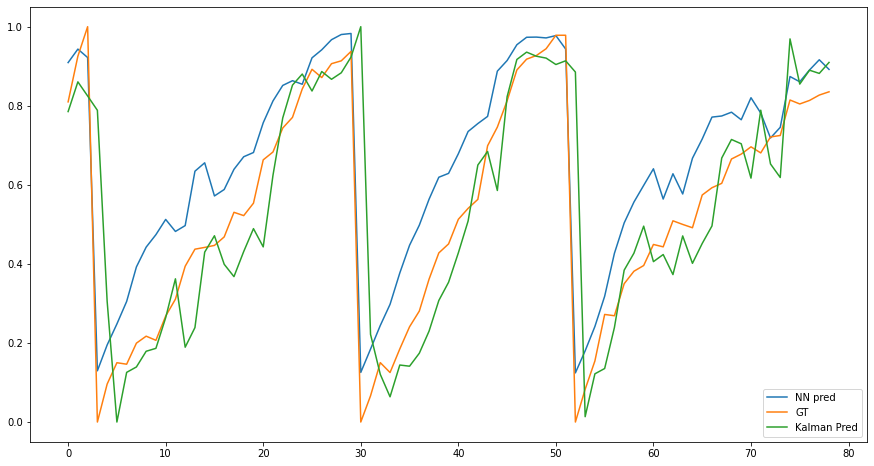

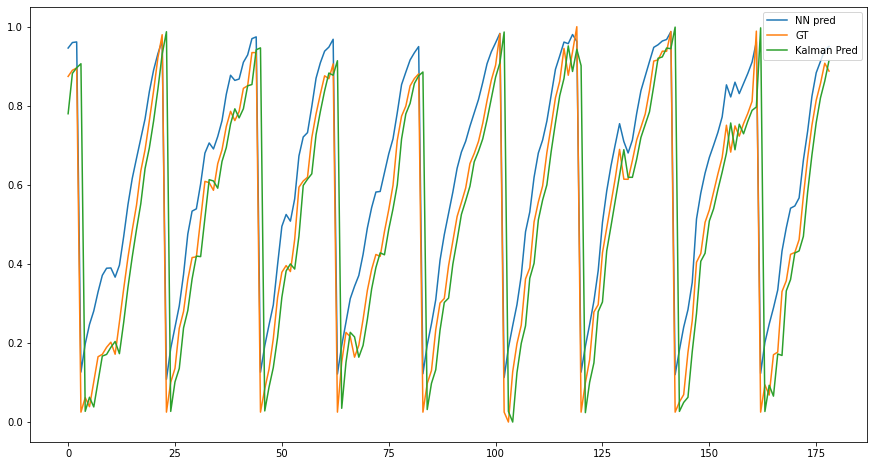

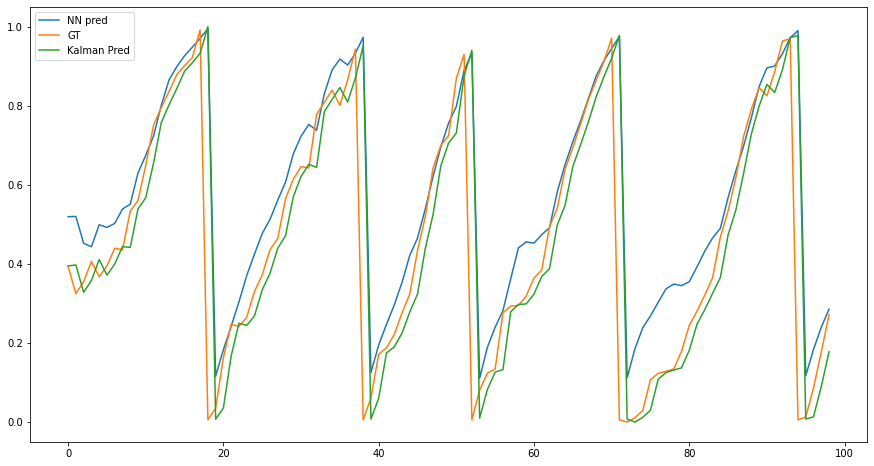

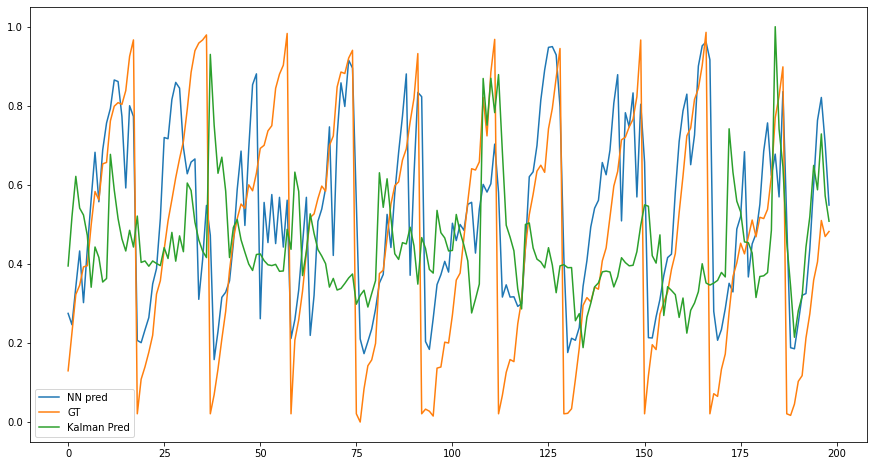

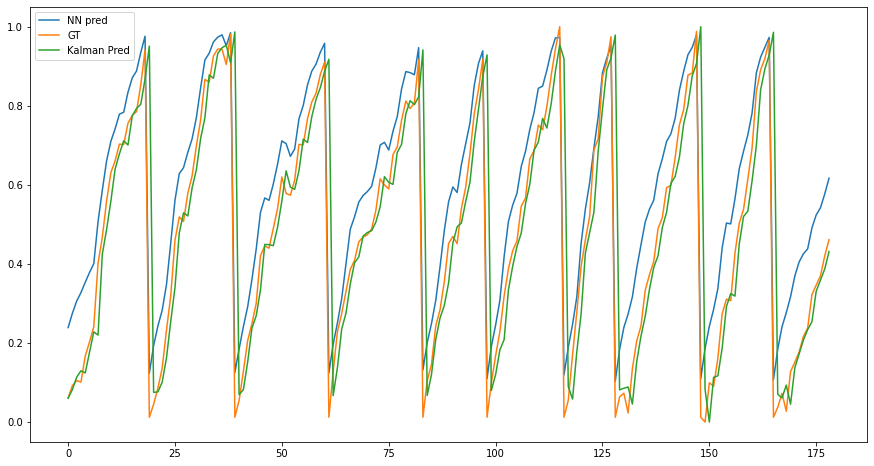

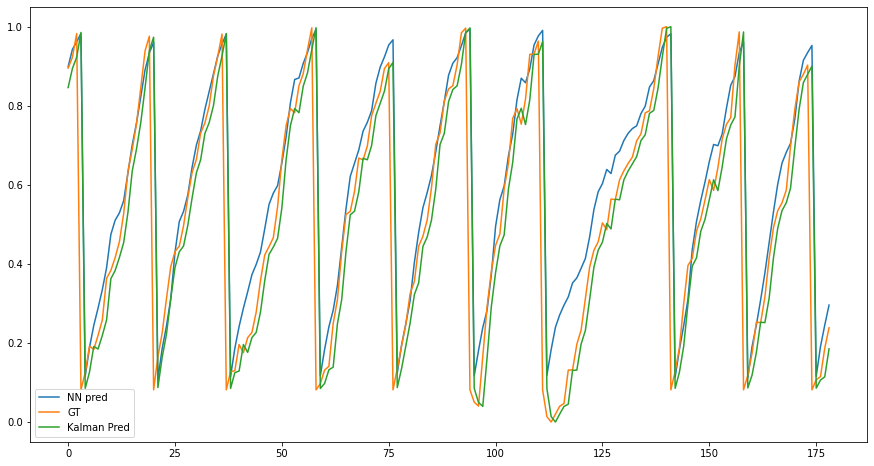

In [29]:
data_dim = 1
model_name = "RNN"
params, test_set_name = test_setup(data_dim=1, model_name=model_name)
params['batch_size'] = 20
rnn_1d_df = get_results(params, test_set_name, model_name=model_name, data_dim=data_dim)
save_results(rnn_1d_df, data_dim=1, model_name=model_name)
rnn_1d_df


## GRU

config: {'dir': '/home/anees.hashmi/Desktop/kalmanfilters_nn/saved_models/appended_mae/experiments_1D/GRU', 'dir_2': '/home/anees.hashmi/ray_results/train_ray_2023-05-08_02-45-55/train_ray_efc9f_00001_1_lr=0.0016,num_layers=12,sequence_length=56_2023-05-08_02-51-54', 'hidden_size': 256, 'lr': 0.0016182754659208602, 'metric': 0.08587069204077125, 'num_layers': 12, 'sequence_length': 56, 'batch_size': 20, 'model_name': 'GRU', 'input_size': 9, 'output_size': 1, 'data_dim': 1, 'json_config_path': './logs/appended_mae/experiments_1D/best_config_GRU.json', 'plot_limit': -1, 'save_plots': True, 'save_dir': './results/1D/GRU/plots', 'eval_dir_path': 'data/1D/evaluation_data', 'loss': 'mae', 'save_name': 'mnst_2_lnstd_1'}
Loading GRU model...
len test loader: 2
Test loss: 0.00887169549241662
Test dataset shape: 3 and  (40, 56, 9)
NN MSE: 0.0749659191984536
KF MSE: 0.08392943150743162
config: {'dir': '/home/anees.hashmi/Desktop/kalmanfilters_nn/saved_models/appended_mae/experiments_1D/GRU', 'dir

Test set Test model  Kalman MAE    NN MAE
0   MNST 3        GRU    0.083929  0.074966
1   MNST 2        GRU    0.096301  0.062441
2   MNST 5        GRU    0.098130  0.106936
3   MNST 0        GRU    0.248742  0.172572
4   MNST 4        GRU    0.090449  0.053124
5   MNST 1        GRU    0.093110  0.091254

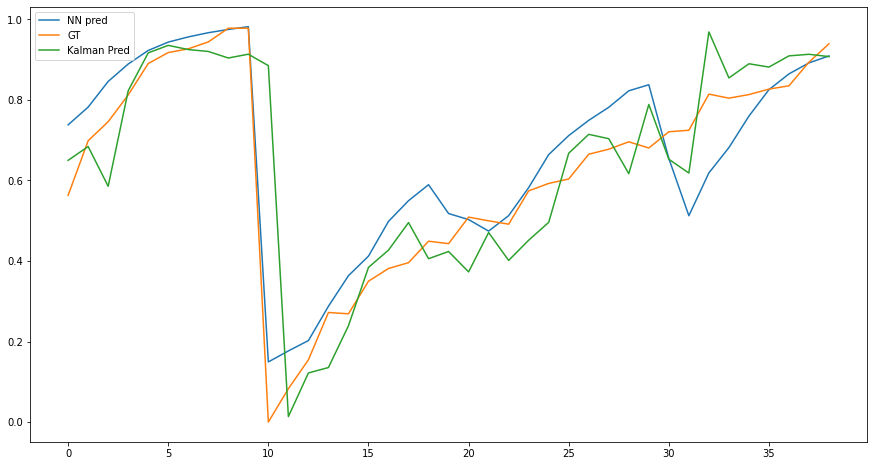

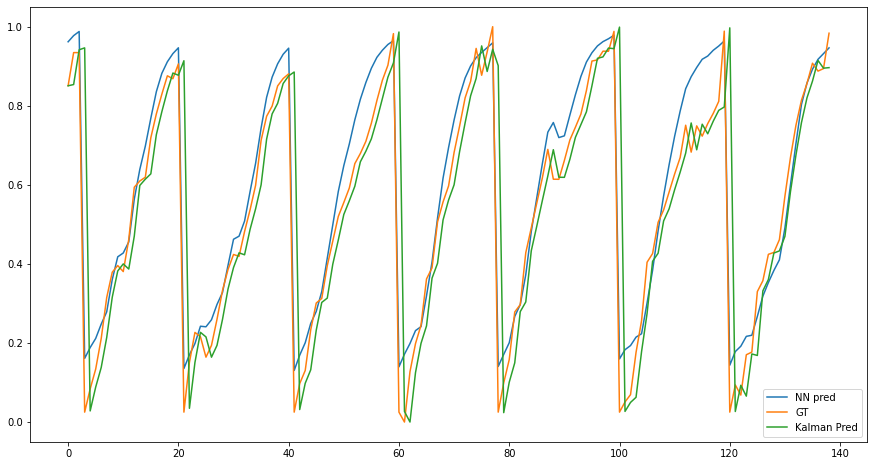

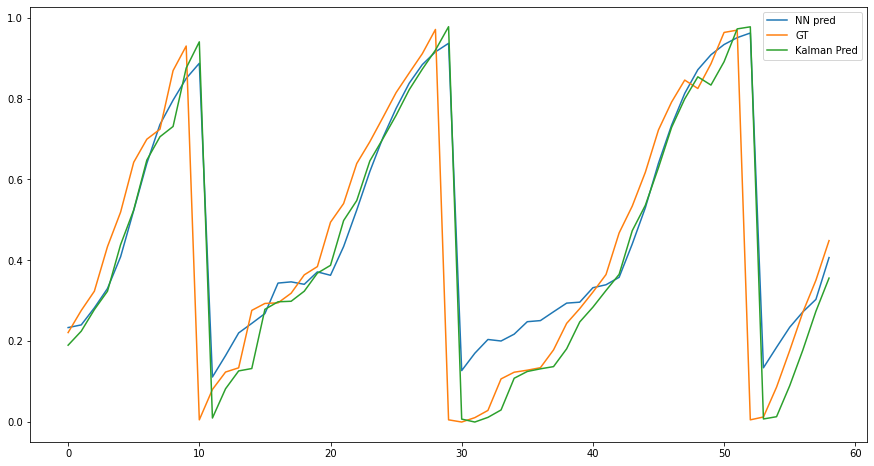

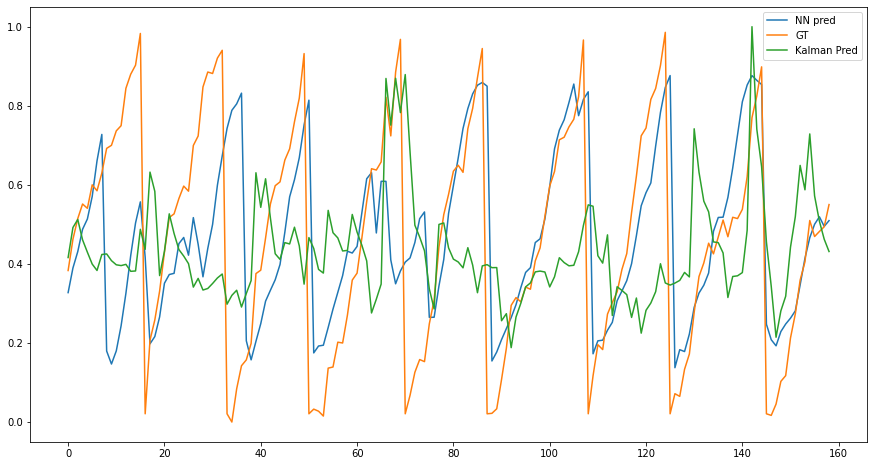

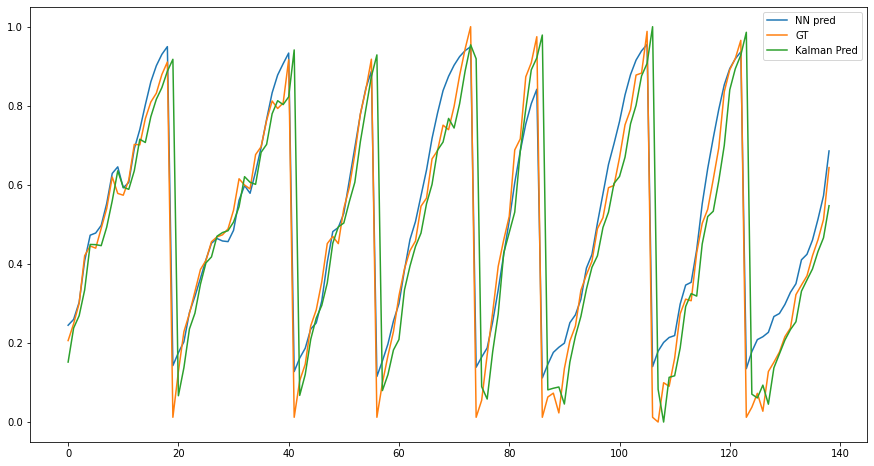

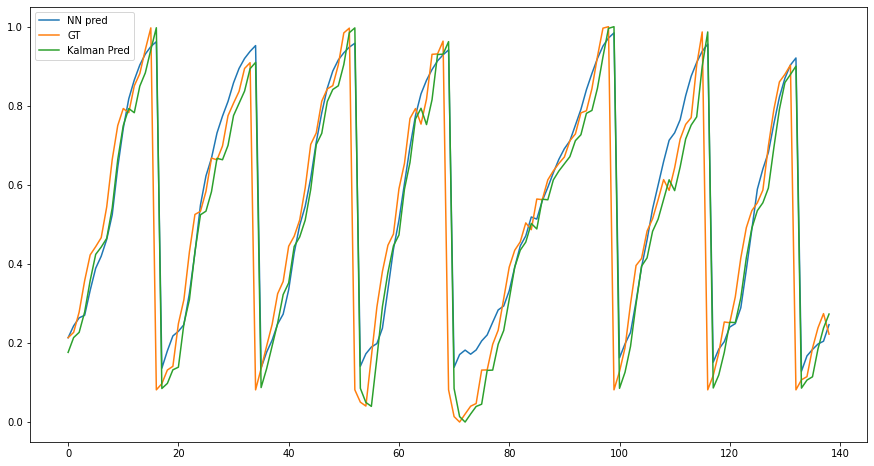

In [30]:
data_dim = 1
model_name = "GRU"
params, test_set_name = test_setup(data_dim=1, model_name=model_name)
params['batch_size'] = 20
rnn_1d_df = get_results(params, test_set_name, model_name=model_name, data_dim=data_dim)
save_results(rnn_1d_df, data_dim=1, model_name=model_name)
rnn_1d_df
